# Understanding Society

Standard access data comes under 3 settings: the main survey (BHPS+UKHLS), the innovation panel survey (survey testbed) and the nurse surveys (UKHLS Waves 2 and 3). Each of the settings have multiple waves, in each of which some questions would overlap while others won't. (For instance, social network information is only in waves 3 and 6 of UKHLS.)

## Links to relevant survey variables

### Main Survey
Socio-demographics:https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/socio-demographic-characteristics

Social networks (mostly wave 3 and 6): https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/social-support-networks

Religion: https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/religion

Psychology (like big 5, cognitive ability, mostly wave 3): https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/psychological-characteristics

Health conditions: https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/health-personal-health-condition

Subjective well-being: https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/health-subjective-well-being

Smoking: https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/health-smoking

Education: https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/education-background-and-attainments

Income: https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/incomes

Employment (BIG): https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/employment-labour-force-status

Opinions and attitudes:https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/values-opinions-and-attitudes

Geography and safety: https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/geographic-location

Environment (mostly wave 4): https://www.understandingsociety.ac.uk/documentation/mainstage/dataset-documentation/index/employment-labour-force-status

### Nurse Visits

Health tests and measurements: https://www.understandingsociety.ac.uk/documentation/health-assessment/dataset-documentation/wave/xwave/datafile/xindresp_ns
Blood biomarkers: https://www.understandingsociety.ac.uk/documentation/health-assessment/dataset-documentation/wave/xwave/datafile/xlabblood_ns

## Accessing Data

Data was collected from UK Data Services. The actual data can be straight-forwardly parsed (see below), however the metadata of variable descriptions are non-trivial to parse (the "data dictionaries" exist in RTF formats!) So we had to go through them the long manual way.

## Cross-Wave Analysis

1. Infer connectivity kernel from Wave 3, 6; which Blau dimensions?
2. Derive individual's social isolation, for all individual respondents, in all waves offering Smoking, Psychology, Health, Well-being
3. Regression from individual isolation to indicators. How?

### TO DO: Regression Strategy
1. Say we pick binary indicators only.
2. Logistic Regression with gaussian additive noise: some kind of a constant scaling of the original weights of the kernel; quite easy to interpret!
3. Alternately to 2, log-reg with "GP" priors: (a) if prior kernel is learnable, we can obtain meta-homophily beyond connectivity (b) if prior kernel is some scaling of connectivity kernel, we again reach an idea similar to 2 except some notion of pairwise isolation instead of individual: however, this can be confounding, (c) a multi-output GP kernel that learns both individual isolation and binary indicator (separable)

## Extracting Relevant USoc Data

In [842]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
datadir = {'ukhls':'./UKDA-6614-tab/tab/ukhls_w', 
           'bhps':'./UKDA-6614-tab/tab/bhps_w', 
           'nurse':'./UKDA-7251-tab/tab/', 
           'ip':'./UKDA-6849-tab/tab/'}

Let's write a function to parse any of the survey datasets into appropriate `pd.DataFrame`s.

In [942]:
def read_data(category='ukhls', wave=3, survey='indresp'):
    from string import ascii_lowercase
    prefix = {'bhps':str(wave)+'/', 'ukhls':str(wave)+'/', 'nurse':'', 'ip':''}
    suffix = {'bhps':'', 'ukhls':'', 'nurse':'_ns', 'ip':'_ip'}
    wave_num2sym = {'bhps': dict(zip(np.arange(1,19), ['b'+s+'_' for s in ascii_lowercase[0:18]])), 
                 'ukhls': dict(zip(np.arange(1,8), [s+'_' for s in ascii_lowercase[0:7]])), 
                 'ip': dict(zip(np.arange(1,11), [s+'_' for s in ascii_lowercase[0:10]])),
                 'nurse': {2:'b',3:'c'}}
    if isinstance(wave, int): wave_sym = wave_num2sym[category][wave]
    else: wave_sym = wave
    datapath = datadir[category] + prefix[category] + wave_sym + survey + suffix[category] + '.tab'
    return {'cat':category, 'wav':wave, 'sym':wave_sym, 'svy':survey, 'tab':pd.read_table(datapath)}

In [939]:
ukhls_3 = read_data('ukhls', 3, 'indresp')

A helper function to query the variables in the survey file; say we are interested in the social network related variables containing the word 'net'.

In [57]:
def query_table(data, query='net'):
    columns = [i for i in list(data['tab']) if query in i]
    return columns

In [36]:
socnet_vars = query_table(ukhls_3, 'net')

### Network Information

We need to extract `(seed, nominee)` pairs from survey data, and the corresponding Blau dimensions. Since all data is encoded into numbers, we map them to appropriate labels if they are categorical variables, or leave them as is for continuous. (Note that negative numbers are mapped to `np.nan`s since they correspond to inappropriate or null values.) The output is a `pd.DataFrame` where every row corresponds to a seed, the column names are blau dimensions, and those suffixed with `#i` are the dimensions of ith nominee.

In [976]:
def extract_nominees(data, n_max=3):
    var_s = {'sex_dv':'sex', 
             'age_dv':'age', 
             'racel_dv':'ethnicity', 
             'jbstat':'employment'
            }
    var_n = {'netsx':'sex', 
             'netag':'age', 
             'netet':'ethnicity', 
             'netjb':'employment_n', 
             'netlv':'distance'
            }
    var_encoding = {'sex':{1:'male', 
                           2:'female'
                          },
                    'ethnicity':{(1, 2, 3, 4):'white', 
                                 (5, 6):('white', 'black'),
                                 7:('white', 'asian'),
                                 (9, 10, 11, 12, 13):'asian',
                                 (14, 15, 16):'black',
                                 (8, 17, 97):'other'
                                },
                    'employment':{(1, 2, 5, 10, 97): 'employed',
                                    (3, 8): 'unemployed',
                                    (7, 9, 11): 'student',
                                    6: 'housework',
                                    4: 'retired'
                                   },
                    'employment_n':{(1,2):'employed',
                                    3:'unemployed',
                                    4:'student',
                                    5:'housework',
                                    6:'retired'
                                   }
                   }
    
    def expand_variable(var_s, var_n):
        if data['sym']=='x': prefix = ''
        else: prefix = data['sym']
        suffix = [str(i) for i in range(1, n_max+1)]
        var_s = dict([(prefix+key, val.split('_')[0]) for key, val in var_s.items()])
        var_n = [[(prefix+key+'_'+s, val.split('_')[0]+'#'+s) for key, val in var_n.items()] for s in suffix]
        var_n = dict([i for j in var_n for i in j])
        return var_s, var_n
    
    def expand_encoding(encoding_dict):
        new_dict = dict()
        for key, value in encoding_dict.items():
            new_d = dict()
            for k, v in value.items():
                if isinstance(k, int): k = (k,)
                if isinstance(v, str): v = (v,)
                v = '&'.join(v)
                for i in k: new_d[i] = v
            new_dict[key] = new_d
        return new_dict
    
    def generate_varcode(var_s, var_n, var_encoding):
        var_s, var_n = expand_variable(var_s, var_n)
        var_encoding = expand_encoding(var_encoding)
        code_s = dict([(key, var_encoding[val.split('#')[0]]) for key, val in var_s.items() if val.split('#')[0] in var_encoding])
        code_n = dict([(key, var_encoding[val.split('#')[0]]) for key, val in var_n.items() if val.split('#')[0] in var_encoding])
        return var_s, var_n, code_s, code_n
    
    var_s, var_n, code_s, code_n = generate_varcode(var_s, var_n, var_encoding)
    data_s = data['tab'].loc[:,var_s.keys()]
    data_s[data_s<0] = None
    data_s.replace(to_replace=code_s, inplace=True)
    data_s.rename(columns=var_s, inplace=True)
    data_n = data['tab'].loc[:,var_n.keys()]
    data_n[data_n<0] = None
    data_n.replace(to_replace=code_n, inplace=True)
    data_n.rename(columns=var_n, inplace=True)
    out = pd.concat([data_s, data_n], axis=1)
    out.index = data['tab']['pidp']
    return out

In [952]:
ukhls_3_net = extract_nominees(ukhls_3)

In [1075]:
ukhls_3_net.head()

,sex,age,ethnicity,employment,sex#1,age#1,ethnicity#1,employment#1,distance#1,sex#2,age#2,ethnicity#2,employment#2,distance#2,sex#3,age#3,ethnicity#3,employment#3,distance#3
pidp,,,,,,,,,,,,,,,,,,,
280165,female,32.0,white,employed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
541285,male,25.0,white,employed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
541965,female,23.0,white,employed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
665045,male,29.0,white,employed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
956765,male,56.0,white,employed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Above, we merely recoded the original data. Now, we compute actual "distances" between Blau dimensions of `(seed, nominee)` pairs. The distance on pth Blau dimensions $f^p(i,j)$ depends on whether data is continuous, in which case $f^p(i,j)=|x^p_i-x^p_j|$, or else if categorical, in which case $f^p(i,j)=x^p_i\neq x^p_j$. In the case where categoricals are sets of elements (such as mixed-race membership), then $f^p(i,j)=1 - \frac{|x^p_i \cap x^p_j|}{|x^p_i \cup x^p_j|}$. The output is a `pd.DataFrame` with columns corresponding to Blau dimensions and rows to `(seed, nominee)` pairs.

In [389]:
def blau_distances(df, dims=['sex','age','ethnicity','employment'], n_max=3):
    var_oi = [d for d in dims if d in list(df)]
    
    def dist_func(a, b):
        if type(a)==type(b)==str:
            set_a = set(a.split('&'))
            set_b = set(b.split('&'))
            return 1. - len(set_a & set_b)/len(set_a | set_b)
        else: 
            try: return abs(a-b)
            except: return np.nan
    
    dfs = []
    idx = []
    for i in range(1, n_max+1):
        dist = []
        for var in var_oi: dist.append(df.apply(lambda x: dist_func(x[var], x[var+'#'+str(i)]), axis=1))
        dfs.append(pd.concat(dist, axis=1).rename(columns=dict(zip(range(len(var_oi)), var_oi))))
    return pd.concat(dfs, axis=0).dropna(axis=0).reset_index(drop=True)

In [1078]:
ukhls_3_dist = blau_distances(ukhls_3_net)

In [1080]:
ukhls_3_dist.describe()

,sex,age,ethnicity,employment
count,102671.000000,102671.000000,102671.000000,102671.000000
mean,0.160951,5.866272,0.061475,0.473883
std,0.367488,8.104713,0.230526,0.499320
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,0.000000
75%,0.000000,7.000000,0.000000,1.000000
max,1.000000,87.000000,1.000000,1.000000


Looking at the mean of these Blau distances makes the case for homophily, in particular it's obvious for categoricals since their mean is easy to interpret (the closer is the mean distane to 0, the similar the seed-nominee pairs are). But, in general, we would be interested in arbitrary Blau "differences" between any two people located in the Blau space, irrespective of whether they are connected or not. (This is helpful in particular for generating the control "non-edges" while inferring the kernel.)

In [1083]:
def blau_differences(df, dims=['sex','age','ethnicity','employment'], num_pairs=10):
    var_oi = [d for d in dims if d in list(df)]
    
    def dist_func(a, b):
        if type(a)==type(b)==str:
            set_a = set(a.split('&'))
            set_b = set(b.split('&'))
            return len(set_a & set_b)/len(set_a | set_b)
        else: 
            try: return abs(a-b)
            except: return np.nan
    
    num_seeds = len(df.index)
    pairs = zip(np.random.randint(num_seeds, size=num_pairs), np.random.randint(num_seeds, size=num_pairs))
    df_subset = df.loc[:, var_oi]
    dfs = []
    idx = []
    for i, j in pairs:
        if i!=j:
            dfs.append(df_subset.apply(lambda x: dist_func(x.iloc[i], x.iloc[j]), axis=0))
            idx.append(str(df.index[i])+'_'+str(df.index[j]))
    out = pd.concat(dfs, axis=1).T
    out.index = idx
    out = out[~out.index.duplicated(keep='first')]
    return out.dropna(axis=0)

In [1084]:
ukhls_3_diff = blau_differences(ukhls_3_net, num_pairs=1000)

In [1085]:
ukhls_3_diff.describe()

,sex,age,ethnicity,employment
count,914.000000,914.000000,914.000000,914.000000
mean,0.500000,20.423414,0.752735,0.399344
std,0.500274,14.970769,0.427195,0.490032
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.000000,0.500000,0.000000
50%,0.500000,17.000000,1.000000,0.000000
75%,1.000000,30.000000,1.000000,1.000000
max,1.000000,73.000000,1.000000,1.000000


Looking at the means for arbitrary pairs of individuals makes the case for homophily much more clear (albeit not quite for employment).

### Health, Wellbeing and Biomarkers

Eventually, we wish to relate social connectedness and/or isolation to health-related outcomes, attitudes and behaviours. There's plenty of "well-being" information in USoc's Main Survey, which we can extract using the function below.

In [977]:
def extract_wellbeing(data):
    if data['cat']!='ukhls': 
        print('please use a ukhls dataset')
        return
    
    var = {'hcondn17':'clinical depression',
           'scsf4a':'mental health meant accomplished less',
           'scsf4b':'mental health meant worked less carefully',
           'scsf6a':'felt calm and peaceful',
           'scsf6b':'had lots of energy',
           'scsf6c':'felt downhearted and depressed',
           'scsf7':'physical or mental health interfered with social life',
           'closenum':'number of close friends',
           'evralc':'ever had an alcoholic drink',
           'frdrg':'frequency of drug use',
           'mlrnot11':'cannot work because of poor health',
           'scghq1_dv':'subjective well-being (likert)',
           'scghq2_dv':'subjective well-being (caseness)',
           'scghqa':'concentration',
           'scghqb':'loss of sleep',
           'scghqc':'playing a useful role',
           'scghqd':'capable of making decisions',
           'scghqe':'constantly under strain',
           'scghqf':'problem overcoming difficulties',
           'scghqg':'enjoy day-to-day activities',
           'scghqh':'ability to face problems',
           'scghqi':'unhappy or depressed',
           'scghqj':'losing confidence',
           'scghqk':'believe worthless',
           'scghql':'general happiness',
           'sclfsat1':'satisfaction with health',
           'sclfsat2':'satisfaction with income',
           'sclfsat7':'satisfaction with amount of leisure time',
           'sclfsato':'satisfaction with life overall',
           'whoruage':'important to who you are: age',
           'whoruedu':'important to who you are: education',
           'whorufam':'important to who you are: family',
           'whorupol':'important to who you are: political beliefs',
           'whorupro':'important to who you are: occupation',
           'whorurac':'important to who you are: ethnicity',
           'whorusex':'important to who you are: gender',
           'yphap':'feel about appearance',
           'yphfm':'feel about family',
           'yphfr':'feel about friends',
           'yphlf':'feel about life as a whole',
           'ypsdqf':'usually on my own',
           'ypsdqg':'usually do as I am told',
           'ypsdqh':'worry a lot',
           'ypsdqj':'constantly fidgeting',
           'ypsdqm':'often unhappy',
           'ypsdqs':'other children bully me',
           'ypsdqx':'many fears',
           'evrsmo':'ever smoke cigarettes',
           'smofrq':'frequency of smoking',
           'ypevrsmo':'ever smoke cigarettes at all',
          }
    
    if data['sym']=='x': prefix = ''
    else: prefix = data['sym']
    var = dict([(prefix+key, val) for key, val in var.items()])
    out = data['tab'].loc[:,var.keys()]
    out[out<0] = None
    out.rename(columns=var, inplace=True)
    out.dropna(axis=1, how='all', inplace=True)
    out.index = data['tab']['pidp']
    return out

In [1087]:
ukhls_3_wellness = extract_wellbeing(ukhls_3)

C:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [1088]:
ukhls_3_wellness.head()

,clinical depression,mental health meant accomplished less,mental health meant worked less carefully,felt calm and peaceful,had lots of energy,felt downhearted and depressed,physical or mental health interfered with social life,number of close friends,ever had an alcoholic drink,frequency of drug use,...,satisfaction with life overall,important to who you are: age,important to who you are: education,important to who you are: family,important to who you are: political beliefs,important to who you are: occupation,important to who you are: ethnicity,important to who you are: gender,ever smoke cigarettes,frequency of smoking
pidp,,,,,,,,,,,,,,,,,,,,,
280165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
541285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
541965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
665045,0.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
956765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Besides these, the Nurse surveys collected other physical health related data in waves 2 and 3 of USoc. Let us first read this category of data, and then extract some physical-health related outputs.

In [974]:
def extract_health(data):
    if data['cat']!='nurse': 
        print('please use a nurse dataset')
        return
    
    var = {'nsex':'sex',
           'confage':'age',
           'ethnic':'ethnicity',
           'jbstat':'employment',
           'wtval':'weight (kg)',
           'htval':'height (cm)',
           'bfpcval':'body fat measurement',
           'bmival':'body mass index (kg/m^2)',
           'numed2':'number of prescribed medicines',
           'htpef':'lung function: peak expiratory flow (L)',
           'htfev':'lung function: forced expiratory capacity at 1 second (L)',
           'htfvc':'lung function: forced vital capacity (L)',
           'htfevfvc':'lung function: fev1/fec',
           'bprespc':'if bp valid',
           'ompulval':'pulse (bpm)',
           'omsysval':'systolic pressure (mm of Hg)',
           'omdiaval':'diastolic pressure (mm of Hg)',
           'ommapval':'mean arterial pressure (mm of Hg)'
          }
    
    var_encoding = {'sex':{1:'male', 
                           2:'female'
                          },
                    'ethnicity':{(1, 2, 3, 4):'white', 
                                 (5, 6):('white', 'black'),
                                 7:('white', 'asian'),
                                 (9, 10, 11, 12, 13):'asian',
                                 (14, 15, 16):'black',
                                 (8, 17, 97):'other'
                                },
                    'employment':{(1, 2, 5, 10, 97): 'employed',
                                    (3, 8): 'unemployed',
                                    (7, 9, 11): 'student',
                                    6: 'housework',
                                    4: 'retired'
                                   }
                   }
    
    def expand_encoding(encoding_dict):
        new_dict = dict()
        for key, value in encoding_dict.items():
            new_d = dict()
            for k, v in value.items():
                if isinstance(k, int): k = (k,)
                if isinstance(v, str): v = (v,)
                v = '&'.join(v)
                for i in k: new_d[i] = v
            new_dict[key] = new_d
        return new_dict
    
    if data['sym']=='x': prefix = ''
    else: prefix = data['sym']
    var = dict([(prefix+key, val) for key, val in var.items()])
    var_encoding = expand_encoding(var_encoding)
    code = dict([(key, var_encoding[val]) for key, val in var.items() if val in var_encoding])
    out = data['tab'].loc[:,var.keys()]
    out[out<0] = None
    out[out[prefix+'bprespc']==1][[prefix+i for i in ['ompulval','omsysval','omdiaval','ommapval']]] = None
    out.replace(to_replace=code, inplace=True)
    del out[prefix+'bprespc']
    out.rename(columns=var, inplace=True)
    out.dropna(axis=1, how='all', inplace=True)
    out.index = data['tab']['pidp']
    return out

In [906]:
nurse = read_data('nurse','x','indresp')

In [978]:
nurse_health = extract_health(nurse)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [981]:
nurse_health.describe()

,age,weight (kg),height (cm),body fat measurement,body mass index (kg/m^2),number of prescribed medicines,lung function: peak expiratory flow (L),lung function: forced expiratory capacity at 1 second (L),lung function: forced vital capacity (L),lung function: fev1/fec,pulse (bpm),systolic pressure (mm of Hg),diastolic pressure (mm of Hg),mean arterial pressure (mm of Hg)
count,20699.000000,20035.000000,20245.000000,18808.000000,19872.000000,20699.000000,16611.000000,16611.000000,16610.000000,16610.000000,16846.000000,16846.000000,16846.000000,16846.000000
mean,50.761293,78.486424,167.397980,30.790999,27.952753,2.069085,7.441394,2.932598,3.836402,0.762420,69.218539,125.877330,72.877894,90.543512
std,18.012186,17.595635,9.605359,10.822496,5.709877,2.881054,2.309388,0.916389,1.098601,0.090998,10.898409,16.779859,10.861180,11.519682
min,16.000000,26.100000,84.199997,5.000000,13.300000,0.000000,1.000000,0.410000,0.580000,0.219251,32.500000,66.500000,32.000000,44.500000
25%,37.000000,65.800003,160.399994,22.799999,24.000000,0.000000,6.000000,2.300000,3.070000,0.717949,61.500000,114.000000,65.500000,82.500000
50%,51.000000,76.500000,166.899994,31.299999,27.200000,1.000000,7.000000,2.890000,3.750000,0.774799,68.500000,124.000000,72.500000,90.000000
75%,65.000000,88.599998,174.300003,39.099998,30.900000,3.000000,9.000000,3.520000,4.540000,0.821519,76.000000,136.000000,80.000000,97.500000
max,102.000000,210.000000,210.399994,65.000000,163.200000,22.000000,18.000000,7.410000,8.310000,1.000000,132.500000,216.000000,126.500000,152.000000


Moreover, the Nurse surveys also included blood samples of many respondents, which were able to generate rich biomarker output such as below.

In [975]:
def extract_biomarkers(data):
    if data['cat']!='nurse': 
        print('please use a nurse dataset')
        return
    
    var = {'alb':'albumin (g/l)',
           'alkp':'alkaline phosphatase (u/l)',
           'alt':'alanine transaminase (u/l)',
           'ast':'aspartate transaminase (u/l)',
           'chol':'cholestrol (mmol/l)',
           'dheas':'didehydroepiandrosterone sulphate (umol/l)',
           'ecre':'creatinine (umol/l)',
           'ggt':'gamma glutamyltransferase (u/l)',
           'hba1c':'glycated haemoglobin (mmol/mol hb)',
           'hdl':'high-density lipoprotein cholesterol (mmol/l)',
           'hscrp':'c-reactive protein (mg/l)',
           'igfi':'insulin-like growth factor 1 (nmol/l)',
           'rtin':'ferritin (ug/l)',
           'testo':'testosterone (nmol/l)',
           'trig':'triglycerides (mmol/l)',
           'ure':'urea (mmol/l)',
           'hgb':'haemoglobin (g/l)',
           'cfib':'clauss fibrinogen (g/l)',
           'uscmg':'cytomegalovirus igg',
           'uscmm':'cytomegalovirus igm',           
          }
    if data['sym']=='x': prefix = ''
    else: prefix = data['sym']
    var = dict([(prefix+key, val) for key, val in var.items()])
    out = data['tab'].loc[:,var.keys()]
    out[out<0] = None
    out.rename(columns=var, inplace=True)
    out.dropna(axis=1, how='all', inplace=True)
    out.index = data['tab']['pidp']
    return out

In [1050]:
nurse_blood = read_data('nurse','x','labblood')

In [1051]:
nurse_biomarkers = extract_biomarkers(nurse_blood)

In [1089]:
nurse_biomarkers.head()

,albumin (g/l),alkaline phosphatase (u/l),alanine transaminase (u/l),aspartate transaminase (u/l),cholestrol (mmol/l),didehydroepiandrosterone sulphate (umol/l),creatinine (umol/l),gamma glutamyltransferase (u/l),glycated haemoglobin (mmol/mol hb),high-density lipoprotein cholesterol (mmol/l),c-reactive protein (mg/l),insulin-like growth factor 1 (nmol/l),ferritin (ug/l),testosterone (nmol/l),triglycerides (mmol/l),urea (mmol/l),haemoglobin (g/l),clauss fibrinogen (g/l),cytomegalovirus igg,cytomegalovirus igm
pidp,,,,,,,,,,,,,,,,,,,,
4626045,46.0,44.0,28.0,38.0,5.0,4.2,94.0,21.0,42.0,1.6,3.3,12.0,59.0,13.4,1.1,8.1,154.0,2.7,1.0,2.0
4626725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68035365,47.0,62.0,81.0,59.0,4.9,5.7,112.0,45.0,59.0,1.2,3.8,23.0,124.0,11.5,3.7,9.3,146.0,3.4,1.0,2.0
68058485,44.0,72.0,26.0,29.0,4.9,3.2,81.0,30.0,41.0,2.0,3.8,15.0,168.0,10.6,1.1,5.3,141.0,2.9,1.0,2.0
68058489,48.0,37.0,18.0,22.0,5.0,7.1,64.0,15.0,38.0,2.2,6.2,13.0,110.0,1.6,0.8,6.5,137.0,2.7,1.0,2.0


### Estimating Social Isolation

We are primarily interested in estimating the relationship between social isolation index (SII) and health indicators such as those extracted above. The good thing about having a connectivity kernel is that once we infer the kernel $\boldsymbol\theta$, we can simply apply it to any subset of the population $\mathcal{X}$ to figure out the pairwise SII $\psi(x_i,x_j)$ on this new subset.

\begin{equation}
\psi(x_i,x_j) \approx -\boldsymbol\theta^Tf(x_i,x_j) = -\sum_p\theta^pf^p(x_i,x_j)
\end{equation}

Mostly, we will be interested in the overall isolation an individual faces in the society. For that, we can always "sum over" all other nodes. However, this can be computational prohibitive since we must evaluate $n^2$ pairwise-SIIs. Let us note that if we are only interested in the individual-SII, we can simply take the expectation of pairwise-SII given position of every other node in the population. Assuming that the distribution of population factorizes over the Blau dimensions, we can write below:

\begin{equation}
\widetilde{\psi(x)} = \sum_p -\theta^p\int f^p(x,y)P^p(y)dy
\end{equation}

Note that $P^p(y)$ is simply the distribution of the population in the pth Blau dimension. This is easy to figure out from a given dataset. We use simple counting for categoricals (while distributing counts equiproportionately for multi-outputs), and Gaussian kernel density estimation for continuous variables. Let us calculate this below.

In [507]:
def estimate_density(df, dims=['sex', 'age', 'ethnicity', 'employment']):
    if dims is None: dims = list(df)
    var_oi = [d for d in dims if d in list(df)]
    
    def discrete_pdf(items):
        counts = dict()
        for item in items:
            if isinstance(item, str):
                it = item.split('&')
                for i in it:
                    if i in counts: counts[i] += 1./len(it)
                    else: counts[i] = 1./len(it)
            else:
                if i in counts: counts[i] += 1.
                else: counts[i] = 1.
        if np.nan in counts: del counts[np.nan]
        if None in counts: del counts[None]
        total = sum(counts.values())
        for k, v in counts.items(): counts[k] = v/total
        return counts
            
    def continuous_pdf(items):
        from scipy.stats import gaussian_kde
        items = np.array(items)
        items = items[~np.isnan(items)]
        pdf = gaussian_kde(items)
        return pdf
    
    density = dict()    
    for var in var_oi:
        if df.dtypes[var] == 'object': density[var] = discrete_pdf(df[var])
        else: density[var] = continuous_pdf(df[var])
    return density    

In [982]:
nurse_health_pdf = estimate_density(nurse_health)

In [1090]:
nurse_health_pdf

{'sex': {'male': 0.43963476496449105, 'female': 0.560365235035509},
 'age': <scipy.stats.kde.gaussian_kde at 0x2163a722400>,
 'ethnicity': {'white': 0.9430165708488333,
  'asian': 0.03142663896806609,
  'black': 0.015363061017440456,
  'other': 0.010193729165660177},
 'employment': {'employed': 0.5435045171264312,
  'retired': 0.27692159041499587,
  'unemployed': 0.07942412676940915,
  'housework': 0.052224745156770856,
  'student': 0.04792502053239287}}

Now, since the kernel parameters $\boldsymbol\theta$ are independent of positions in the Blau space, they remain as constants outside the expectation. Which means we can simply precalculate the expectation of distances
\begin{equation}
\mathbb{E}_{P^p}[f(x)] = \int f^p(x,y)P^p(y)dy
\end{equation}

And then estimate individual-SII as
\begin{equation}
\widetilde{\psi(x)} = \sum_p -\theta^p\mathbb{E}_{P^p}[f(x)]
\end{equation}

#### Aside on Standardization
Since we wish to make expected "distances" (and eventually contributions to SII) of various blau dimensions comparable, we use [Gelman](http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf)'s idea of dividing continuous random variables by two standard deviations to make them readily comparable to 0/1 categoricals.

In [1002]:
def distance_density(df, pdfs, standardize=True, scale=None, num_bins=100):
    if scale is None:
        scale = dict(zip(pdfs.keys(), np.ones(len(pdfs))))
    elif isinstance(scale, int) or isinstance(scale, float):
        scale = dict(zip(pdfs.keys(), scale*np.ones(len(pdfs))))
    else:
        for var in pdfs:
            if var not in scale: scale[var] = 1.0
        
    def discrete_dist(xs, pdf, theta=1.0):
        index_set = set(pdf.keys())
        dist = dict()
        dist_xs = []
        w_comp = 1
        for x in xs:
            if x not in dist:
                if isinstance(x, str):
                    x_ = set(x.split('&'))
                    x_comp = index_set - x_
                    w_ = 1-1/len(x_)                
                    dist[x] = theta*(sum([w_*pdf[x_i] for x_i in x_]) + sum([w_comp*pdf[x_i] for x_i in x_comp]))
                    dist_xs.append(dist[x])
                elif np.isnan(x): dist_xs.append(np.nan)
                else:
                    dist[x] = theta*sum([w_comp*pdf[x_i] for x_i in index_set if x_i != x])
                    dist_xs.append(dist[x])
            else: dist_xs.append(dist[x])
        return dist_xs, dist
    
    def continuous_dist(xs, pdf, num_bins, theta=1.0):
        if standardize: norm_cons = 2.*np.sqrt(np.nanvar(xs))
        else: norm_cons = 1.
        index_set = np.linspace(np.nanmin(xs), np.nanmax(xs), num=num_bins)
        step_size = (np.nanmax(xs) - np.nanmin(xs))/num_bins
        pdf = np.pad(pdf.pdf(index_set), 1, mode='constant')
        dist = []
        dist_xs = []
        
        for i in range(num_bins):
            val = 0.0
            for k in range(1, max(i, num_bins+1-i)):
                val += (pdf[min(i+k, num_bins+1)] + pdf[max(i-k, 0)])*k
            dist.append(theta*val*step_size*step_size/norm_cons)
            
        xs_ = np.digitize(xs, index_set)-1
        for i in range(len(xs)):
            if xs.iloc[i] is None or np.isnan(xs.iloc[i]): dist_xs.append(np.nan)
            else: dist_xs.append(dist[xs_[i]])
            
        return dist_xs, {'index':index_set.tolist(), 'value':dist}
    
    dists_xs = dict()
    dists = dict()
    for var, pdf in pdfs.items():
        if isinstance(pdf, dict): dists_xs[var], dists[var] = discrete_dist(df[var], pdf, scale[var])
        else: dists_xs[var], dists[var] = continuous_dist(df[var], pdf, num_bins, scale[var])    
    return pd.DataFrame(dists_xs, index=df.index), dists

In [1092]:
nurse_dist = distance_density(nurse_health, nurse_health_pdf)

In [1096]:
nurse_dist[0].describe()

,sex,age,ethnicity,employment
count,20699.000000,20699.000000,20535.000000,20685.000000
mean,0.492712,0.555582,0.109046,0.616667
std,0.059925,0.160205,0.209529,0.188525
min,0.439635,0.402377,0.056983,0.456495
25%,0.439635,0.424782,0.056983,0.456495
50%,0.439635,0.492691,0.056983,0.456495
75%,0.560365,0.637712,0.056983,0.723078
max,0.560365,1.345313,0.989806,0.952075


Looking at the sample mean of the expected distances shows that on average people are "more distant" on employment, followed by age, followed by sex and then ethnicity.

Say we are somehow "given" the kernel parameters $\boldsymbol\theta$ (from Till's work, just as proof-of-concept for now). Now, we can figure out this kernel-weighted expected distance, the sum of which across all Blau dimensions is simply the individual-SII.

In [1097]:
THETA = {'sex':1.75,'age':5.0,'ethnicity':1.0,'employment':0.5}

In [1100]:
nurse_dist_kern = distance_density(nurse_health, nurse_health_pdf, scale=THETA)

In [1101]:
nurse_sii = nurse_dist_kern[0].sum(axis=1)

In [1102]:
nurse_sii.describe()

count    20699.000000
mean         4.056463
std          0.872180
min          2.966822
25%          3.374744
50%          3.773620
75%          4.529785
max          8.007828
dtype: float64

That is, the average social isolation in the population is about 4, a minimum around 3 and a maximum around 8.

### Comparing Individual-SII to Individual Health-Outcome

Ideally, we'd like to perform a regression from inferred individual-SII to health outcomes. However below, we do some scatter plots to get a visual idea of whether these two correlate at all.

In [1069]:
def plot_data(x_axis, data, xlab='social isolation index'):
    indicators = list(data)
    x_axis.name = xlab
    data = data.join(x_axis, how='inner')
    keeps = pd.isna(data)
    for indicator in indicators:
        print(indicator)
        keep = ~ (keeps[xlab] | keeps[indicator])
        plt.xlabel(xlab)
        plt.ylabel(indicator)
        plt.scatter(data[xlab][keep], data[indicator][keep])
        plt.show()

#### Relation to Subjective Well-being

There's a strong caveat in interpreting these plots: since "fewer" people hive a higher SII, they are more likely to exhibit a closer-to-mean behaviour. In the light of that, it's not immediately apparent if there is a relationship between individual-SII and wellness.

Note on interpreting indicators:
1. On the 1-5 scale questions, 1 refers to "all of the time" and 5 to "none of the time".
2. On the 1-4 scale questions, 1 refers to "better than usual" and 4 to "much less than usual".
3. On the 1-7 scale questions, 1 refers to "completely dissatisfied" and 7 to "completely satisfied".
4. On the 1-5 scale questions on importance, 1 refers to "very important", 4 to "not at all important" and 5 to NA.

clinical depression


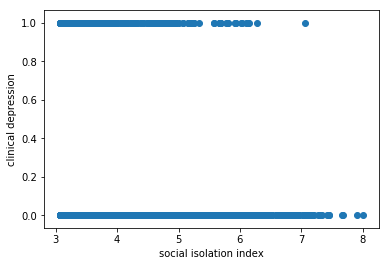

mental health meant accomplished less


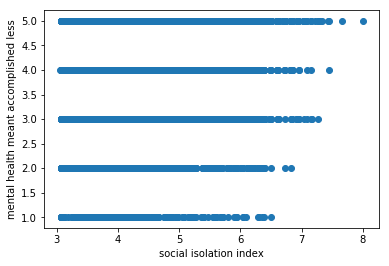

mental health meant worked less carefully


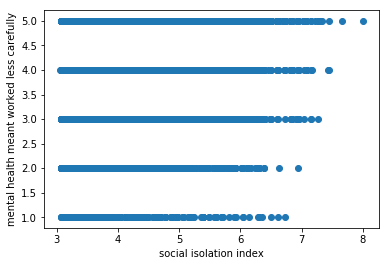

felt calm and peaceful


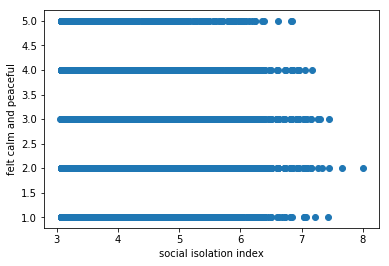

had lots of energy


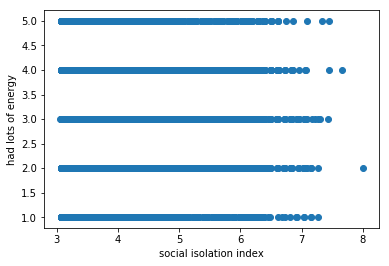

felt downhearted and depressed


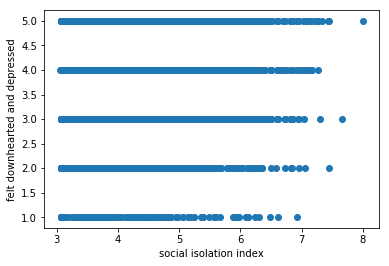

physical or mental health interfered with social life


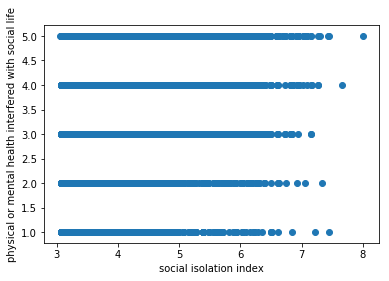

number of close friends


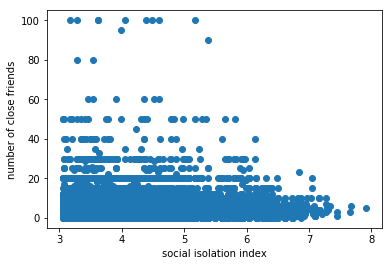

ever had an alcoholic drink


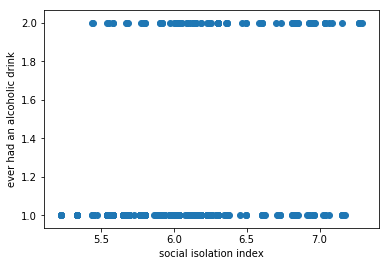

frequency of drug use


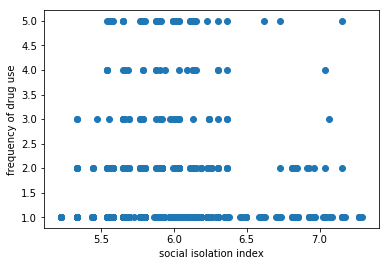

cannot work because of poor health


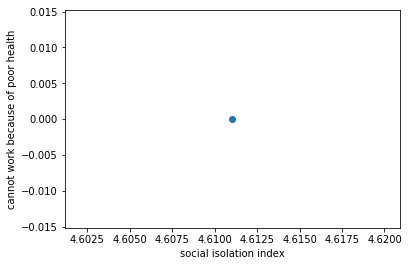

subjective well-being (likert)


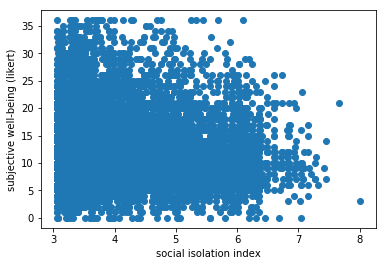

subjective well-being (caseness)


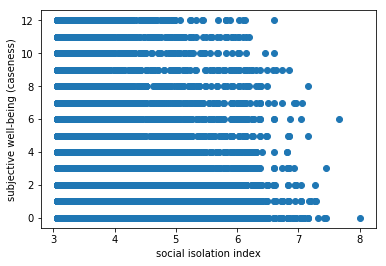

concentration


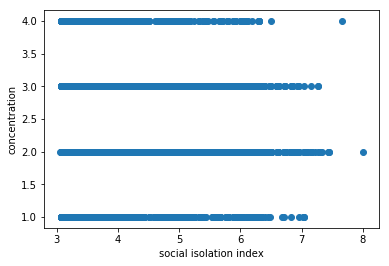

loss of sleep


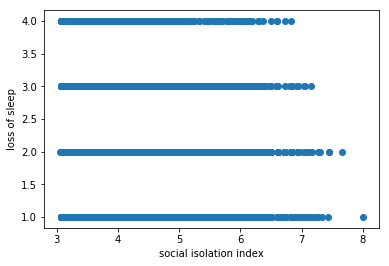

playing a useful role


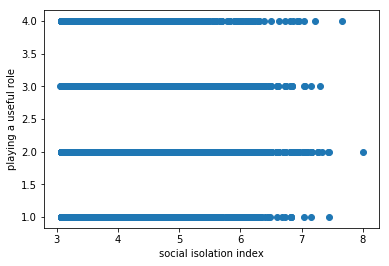

capable of making decisions


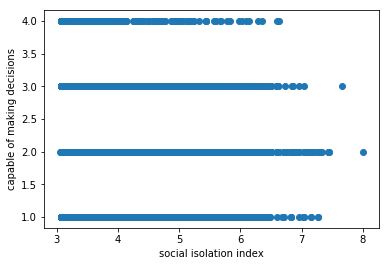

constantly under strain


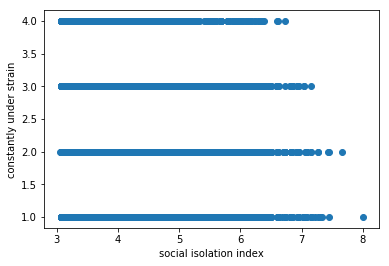

problem overcoming difficulties


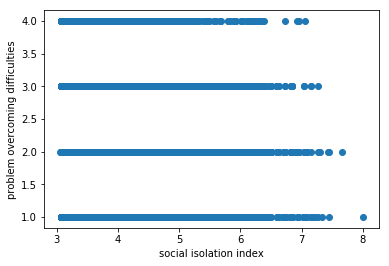

enjoy day-to-day activities


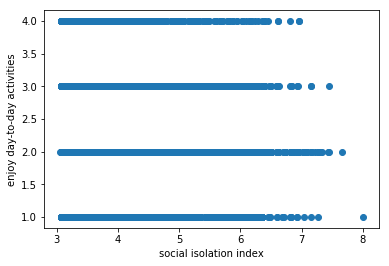

ability to face problems


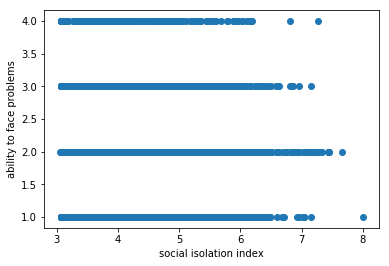

unhappy or depressed


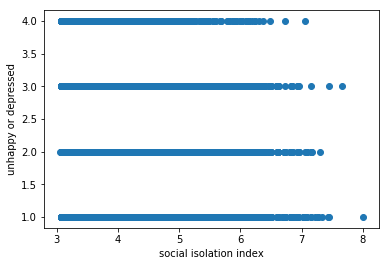

losing confidence


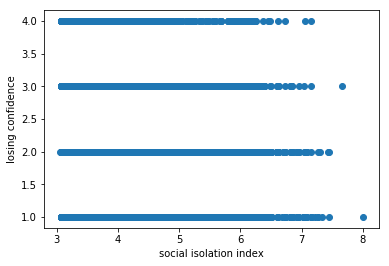

believe worthless


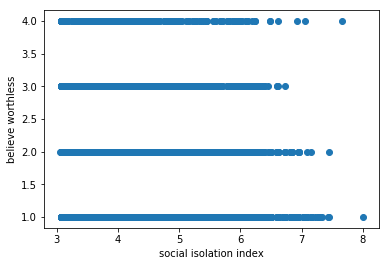

general happiness


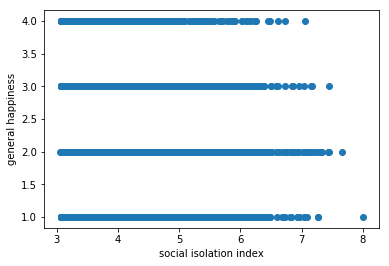

satisfaction with health


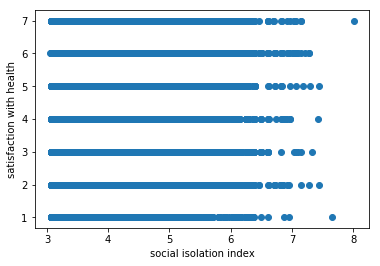

satisfaction with income


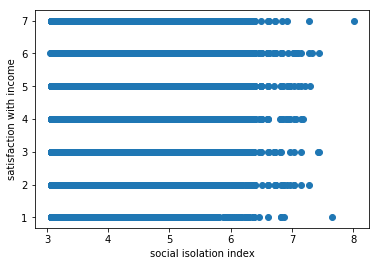

satisfaction with amount of leisure time


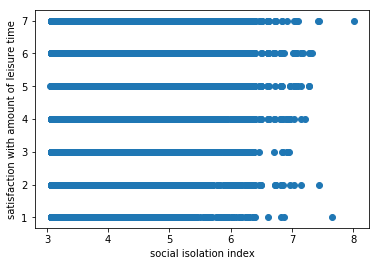

satisfaction with life overall


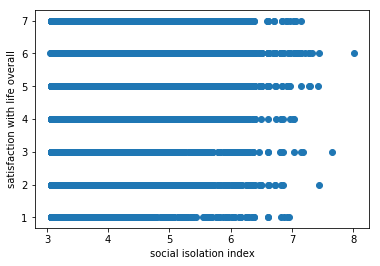

important to who you are: age


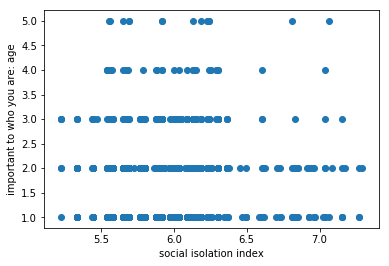

important to who you are: education


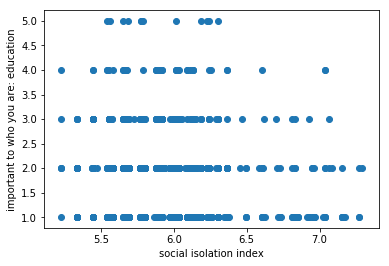

important to who you are: family


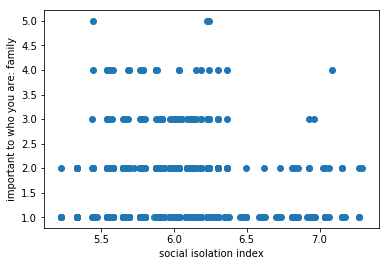

important to who you are: political beliefs


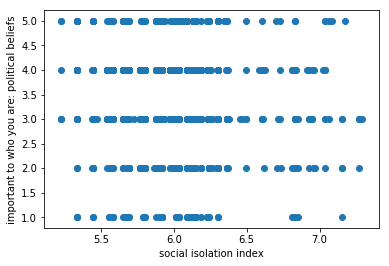

important to who you are: occupation


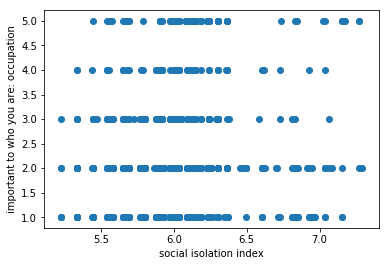

important to who you are: ethnicity


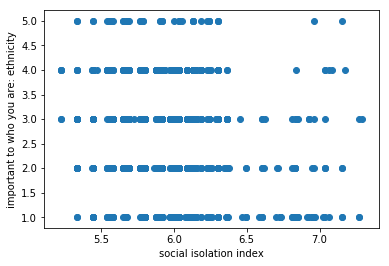

important to who you are: gender


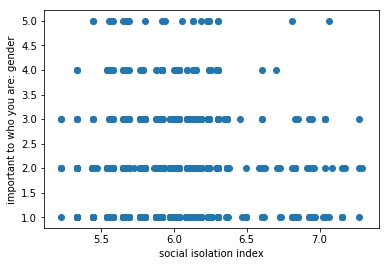

ever smoke cigarettes


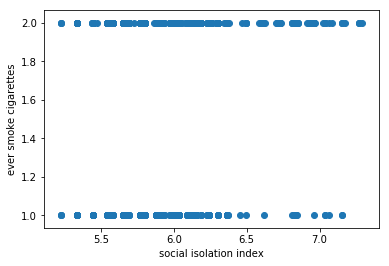

frequency of smoking


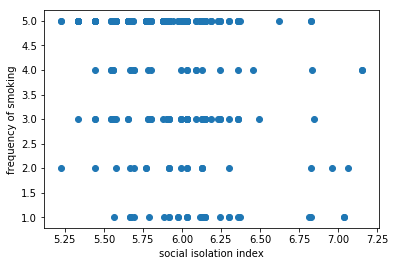

In [1103]:
plot_data(nurse_sii, ukhls_3_wellness)

Age is expected to be a key explanatory variable in such cases, so let us repeat the visualization with Age instead of SII.

clinical depression


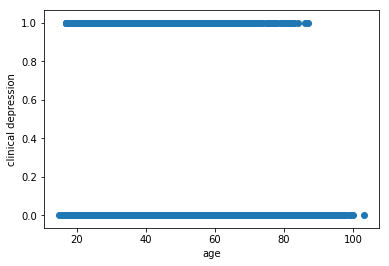

mental health meant accomplished less


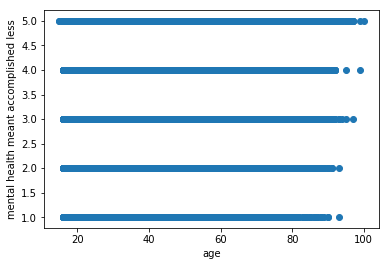

mental health meant worked less carefully


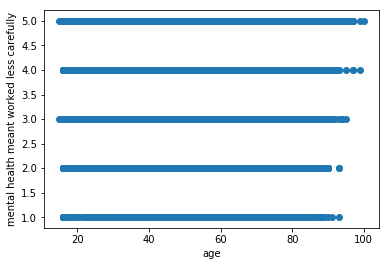

felt calm and peaceful


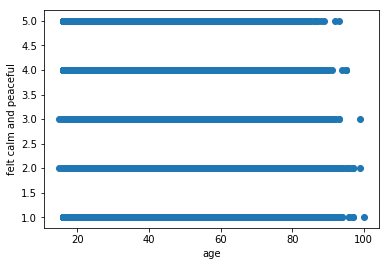

had lots of energy


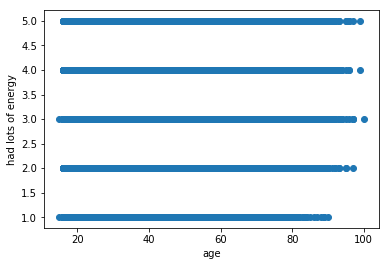

felt downhearted and depressed


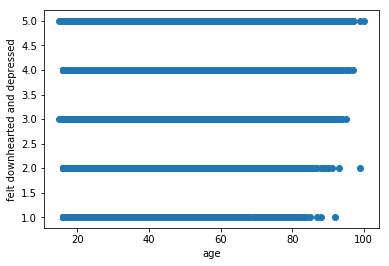

physical or mental health interfered with social life


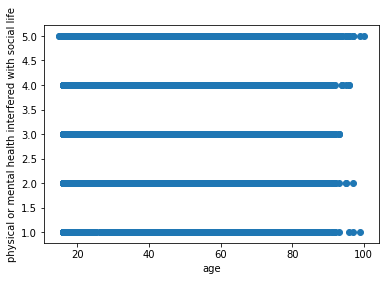

number of close friends


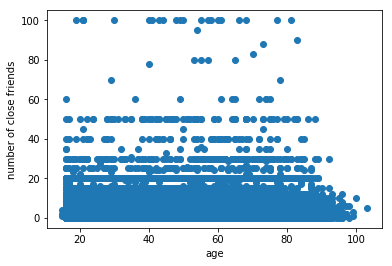

ever had an alcoholic drink


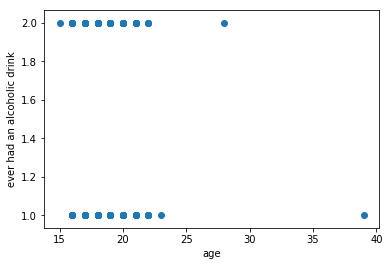

frequency of drug use


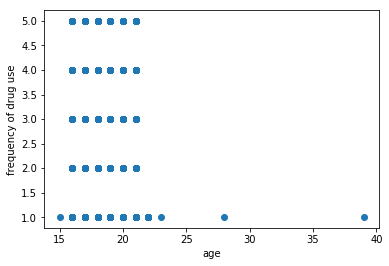

cannot work because of poor health


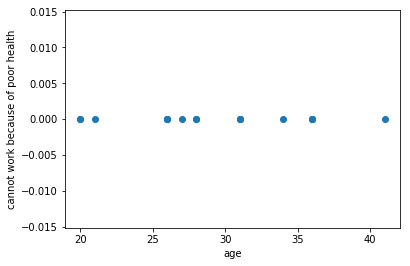

subjective well-being (likert)


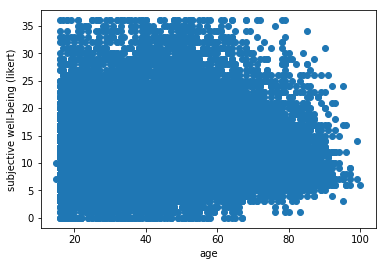

subjective well-being (caseness)


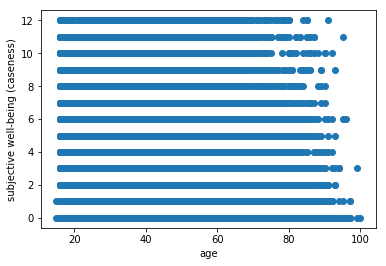

concentration


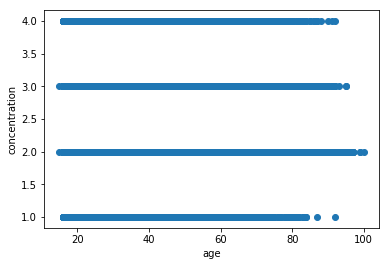

loss of sleep


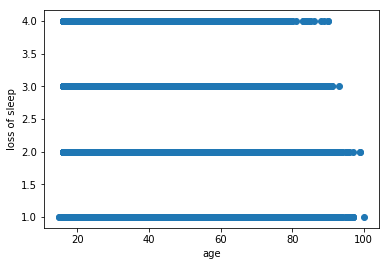

playing a useful role


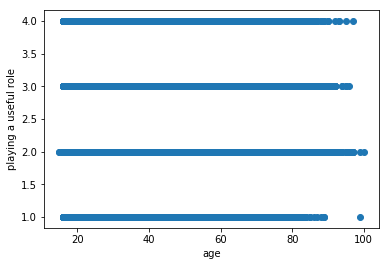

capable of making decisions


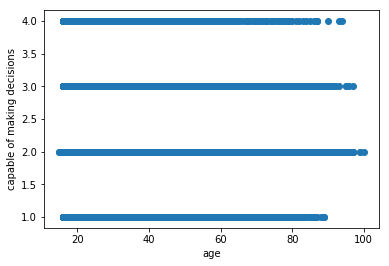

constantly under strain


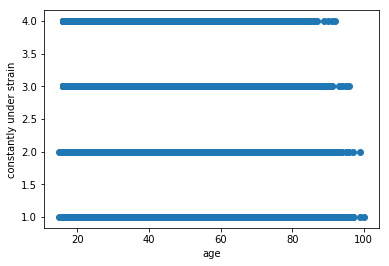

problem overcoming difficulties


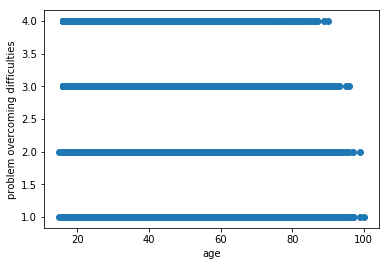

enjoy day-to-day activities


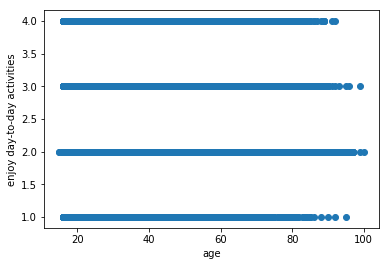

ability to face problems


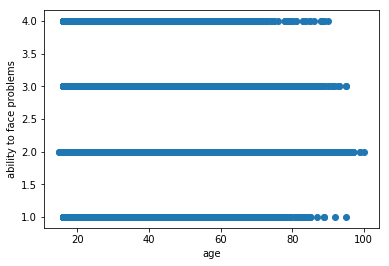

unhappy or depressed


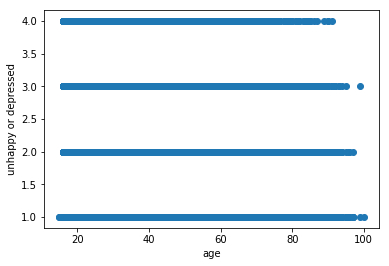

losing confidence


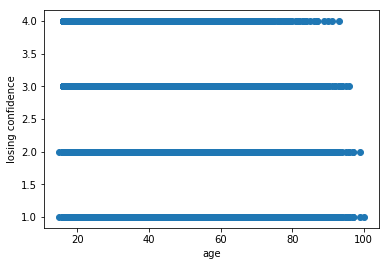

believe worthless


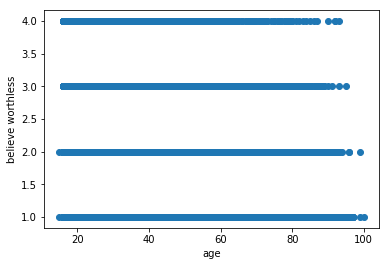

general happiness


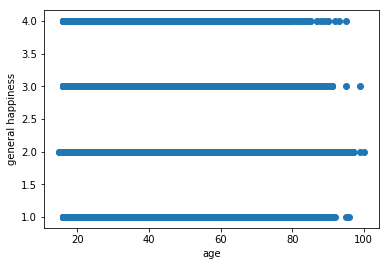

satisfaction with health


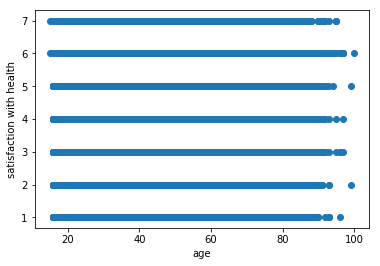

satisfaction with income


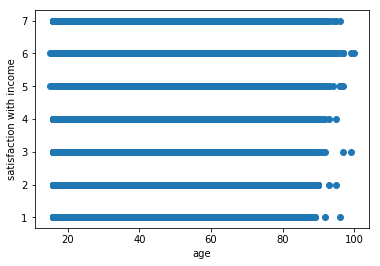

satisfaction with amount of leisure time


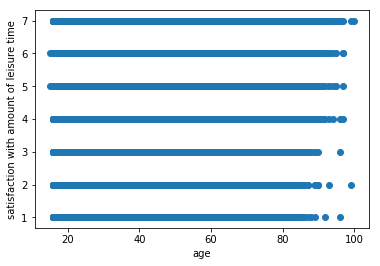

satisfaction with life overall


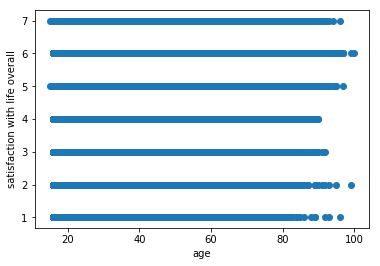

important to who you are: age


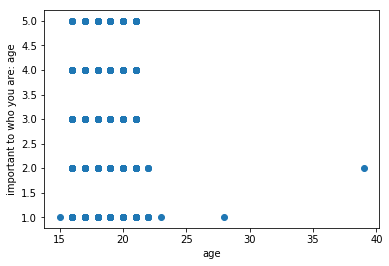

important to who you are: education


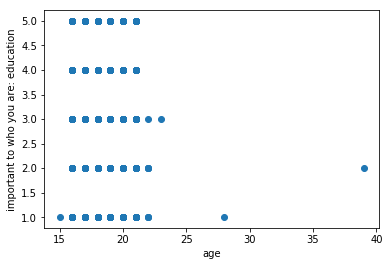

important to who you are: family


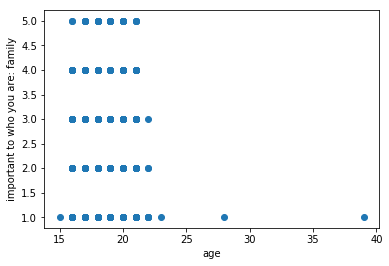

important to who you are: political beliefs


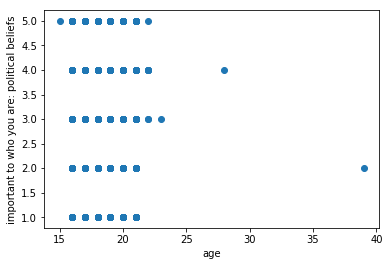

important to who you are: occupation


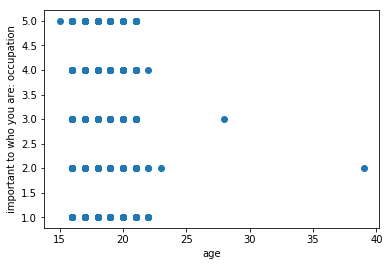

important to who you are: ethnicity


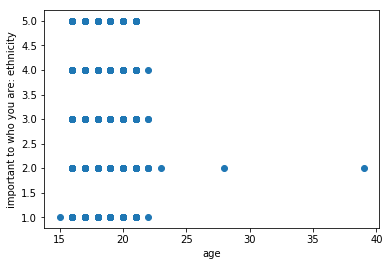

important to who you are: gender


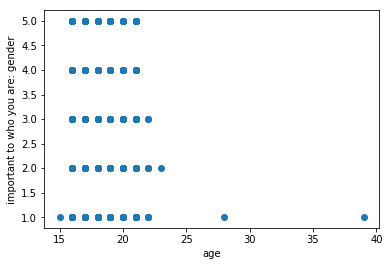

ever smoke cigarettes


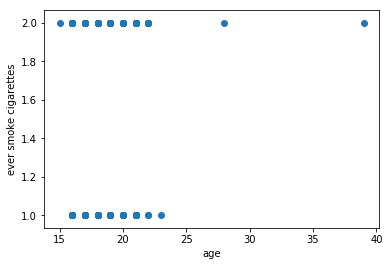

frequency of smoking


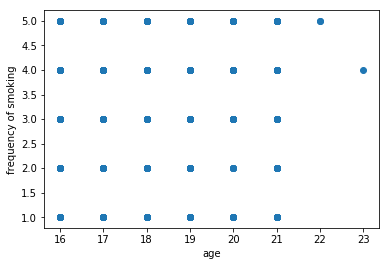

In [1106]:
plot_data(ukhls_3_net['age'], ukhls_3_wellness, 'age')

#### Relation to Physical Health Outcomes

There is no apparent relationship between individual SII and physical health indicators.

sex


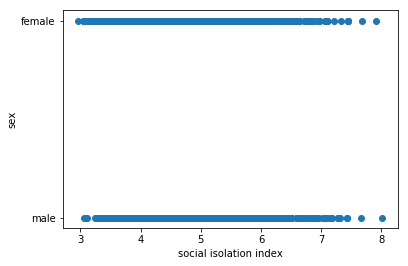

age


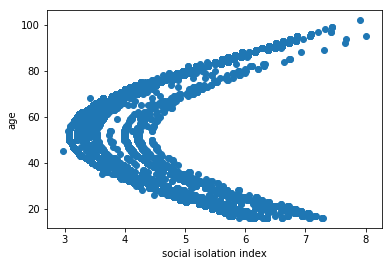

ethnicity


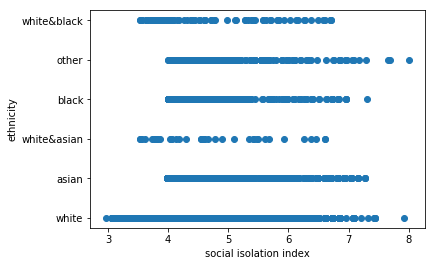

employment


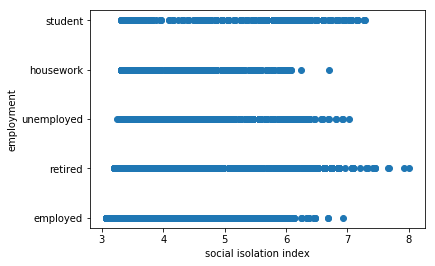

weight (kg)


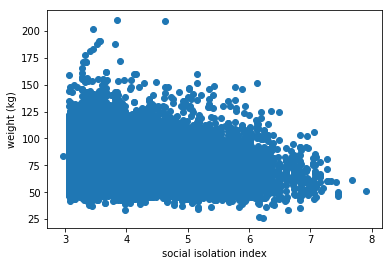

height (cm)


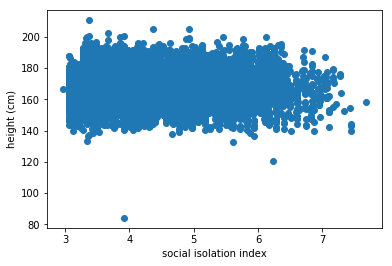

body fat measurement


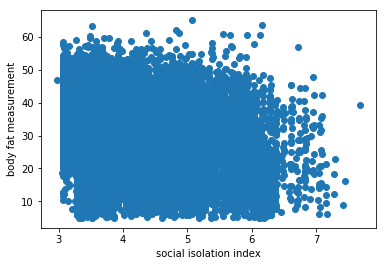

body mass index (kg/m^2)


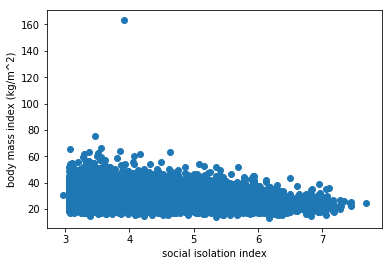

number of prescribed medicines


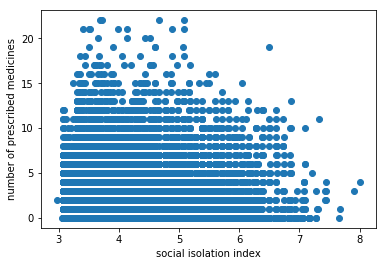

lung function: peak expiratory flow (L)


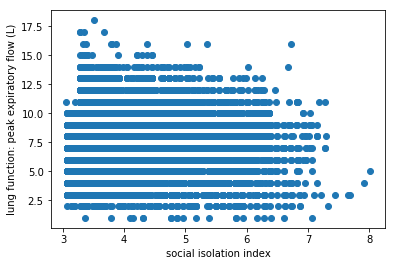

lung function: forced expiratory capacity at 1 second (L)


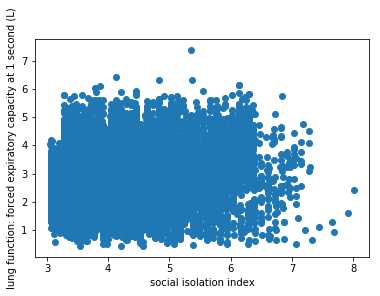

lung function: forced vital capacity (L)


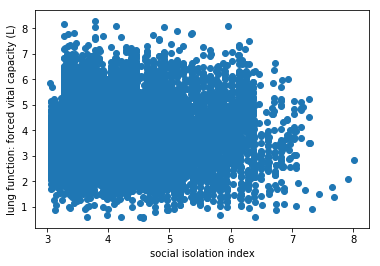

lung function: fev1/fec


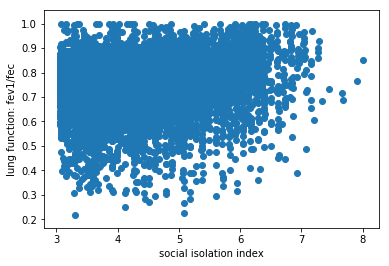

pulse (bpm)


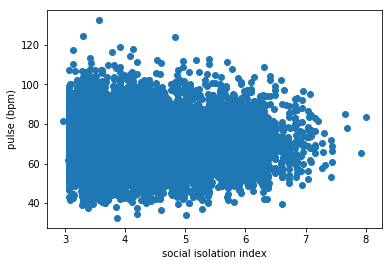

systolic pressure (mm of Hg)


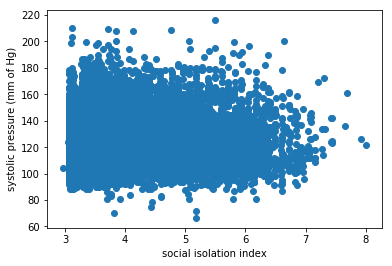

diastolic pressure (mm of Hg)


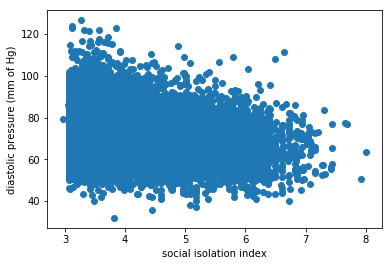

mean arterial pressure (mm of Hg)


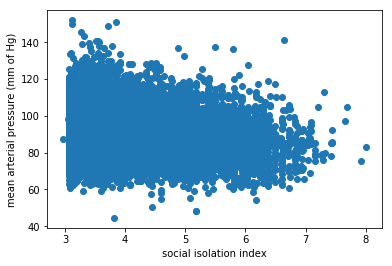

In [1070]:
plot_data(nurse_sii, nurse_health)

sex


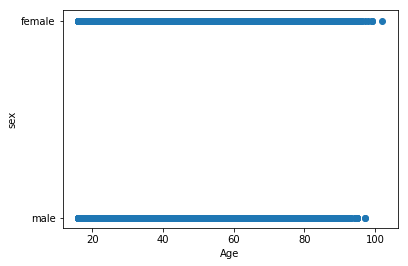

age


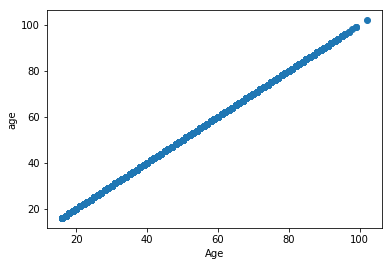

ethnicity


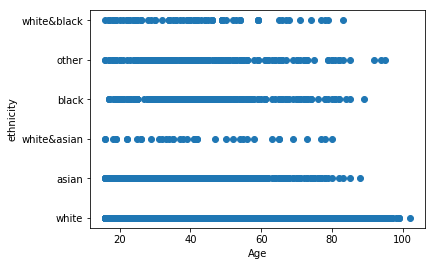

employment


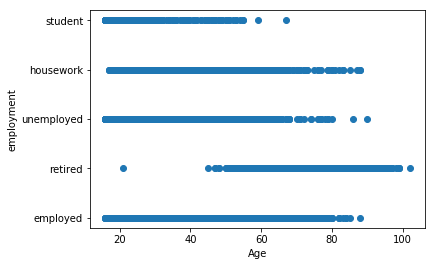

weight (kg)


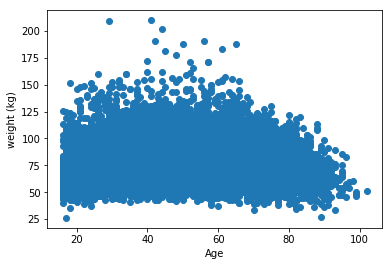

height (cm)


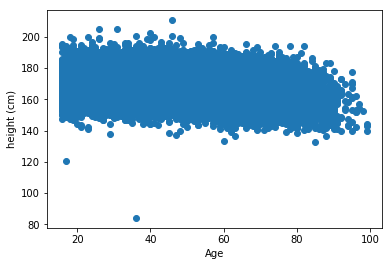

body fat measurement


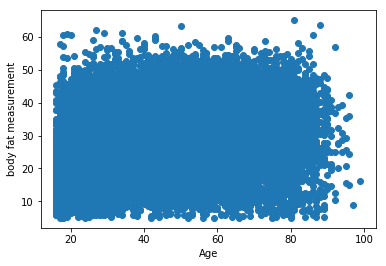

body mass index (kg/m^2)


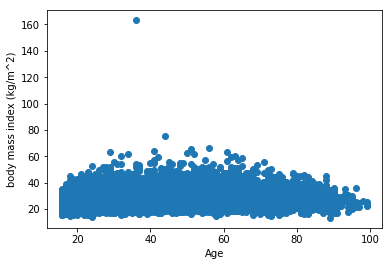

number of prescribed medicines


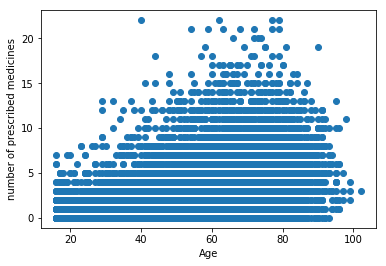

lung function: peak expiratory flow (L)


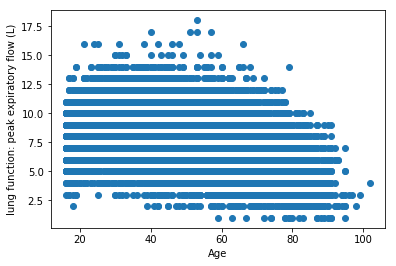

lung function: forced expiratory capacity at 1 second (L)


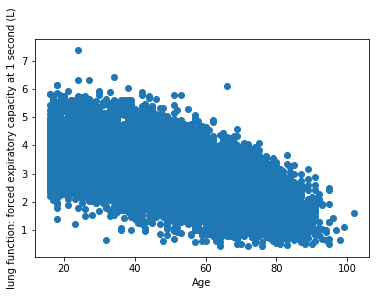

lung function: forced vital capacity (L)


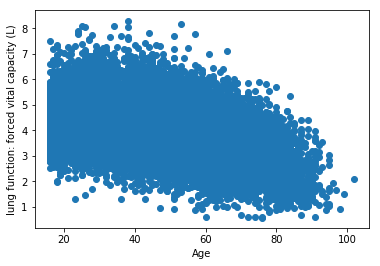

lung function: fev1/fec


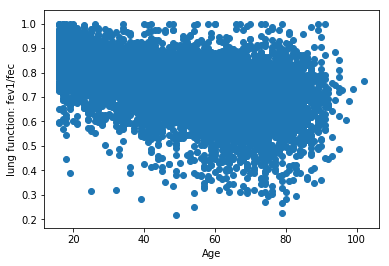

pulse (bpm)


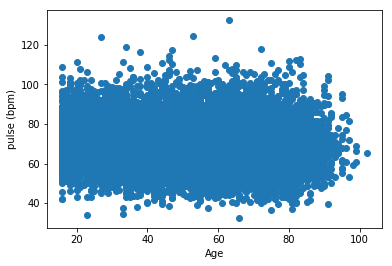

systolic pressure (mm of Hg)


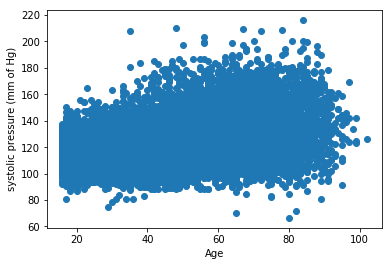

diastolic pressure (mm of Hg)


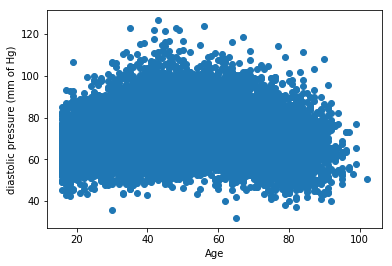

mean arterial pressure (mm of Hg)


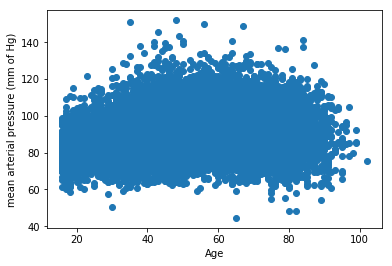

In [1108]:
plot_data(nurse_health['age'], nurse_health, 'Age')

#### Relationship to Biological Markers

There seem to be some apperent patterns, in particular with 
1. [Insulin-like growth factor 1](https://en.wikipedia.org/wiki/Insulin-like_growth_factor_1), a growth hormone
2. [Didehydroepiandrosterone Sulphate](https://en.wikipedia.org/wiki/Dehydroepiandrosterone_sulfate), a neurosteroid
3. [Cholestrol](https://en.wikipedia.org/wiki/Insulin-like_growth_factor_1)
4. [Gamma Glutamyltransferase](https://en.wikipedia.org/wiki/Gamma-glutamyltransferase), an enzyme found in the liver and associated with liver disease
5. [Glycated haemoglobin](https://en.wikipedia.org/wiki/Glycated_hemoglobin) which is associated with the blood sugar levels

albumin (g/l)


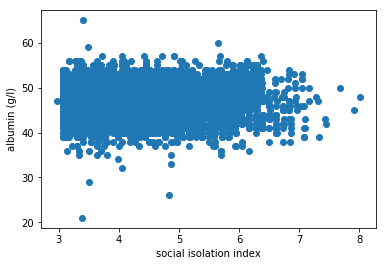

alkaline phosphatase (u/l)


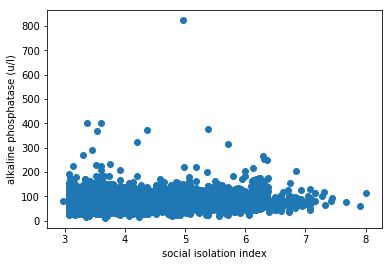

alanine transaminase (u/l)


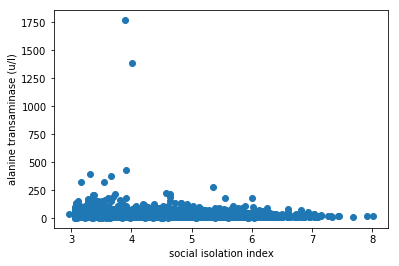

aspartate transaminase (u/l)


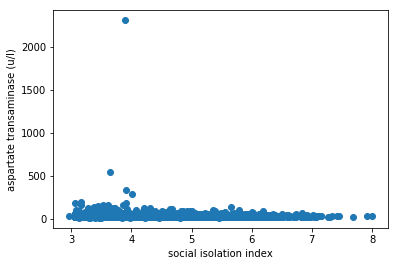

cholestrol (mmol/l)


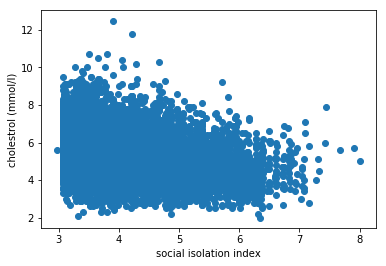

didehydroepiandrosterone sulphate (umol/l)


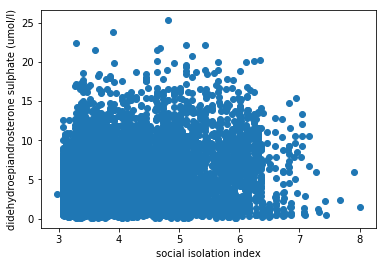

creatinine (umol/l)


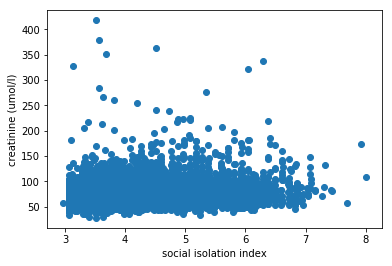

gamma glutamyltransferase (u/l)


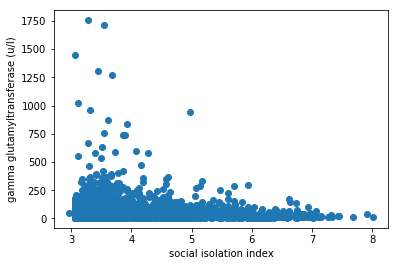

glycated haemoglobin (mmol/mol hb)


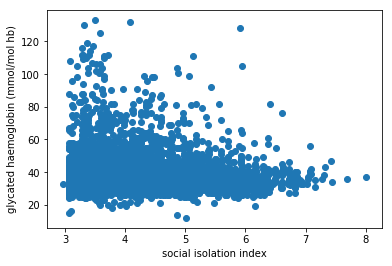

high-density lipoprotein cholesterol (mmol/l)


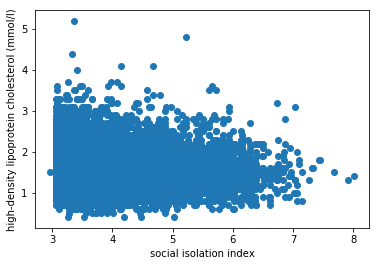

c-reactive protein (mg/l)


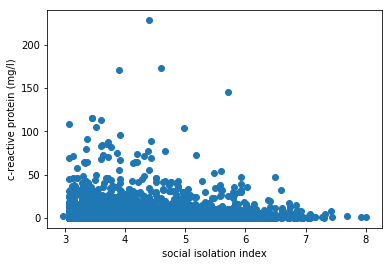

insulin-like growth factor 1 (nmol/l)


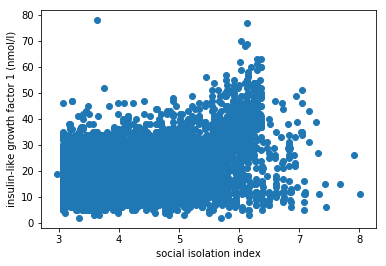

ferritin (ug/l)


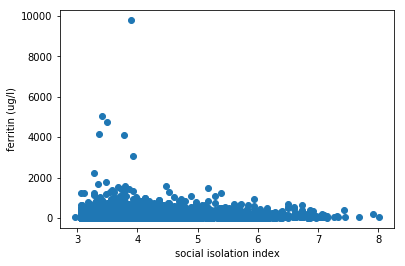

testosterone (nmol/l)


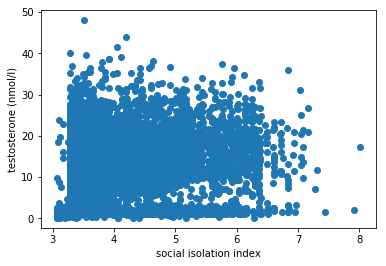

triglycerides (mmol/l)


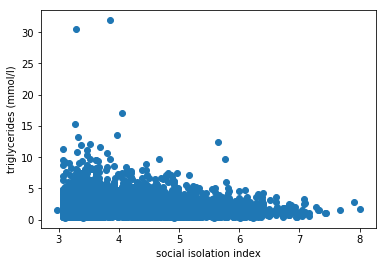

urea (mmol/l)


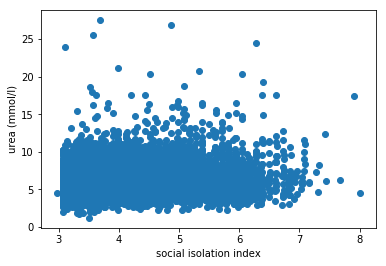

haemoglobin (g/l)


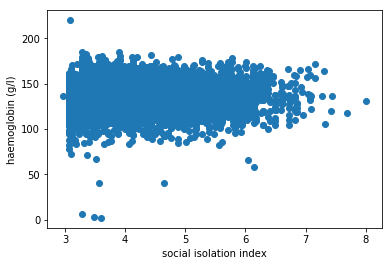

clauss fibrinogen (g/l)


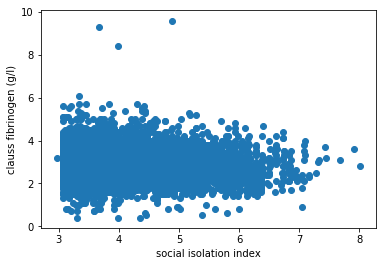

cytomegalovirus igg


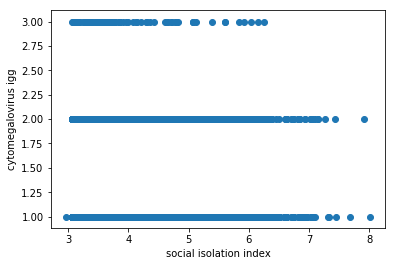

cytomegalovirus igm


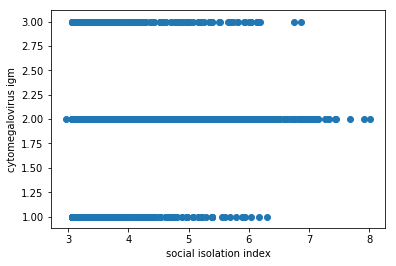

In [1071]:
plot_data(nurse_sii, nurse_biomarkers)

All of these are potentially directly affected by age, which happens to be an important contributer to individual-SII. However, age might just be a "better" explanatory variable for these biomarkers. As before, let us look at that by visualizing them against the age variable.

albumin (g/l)


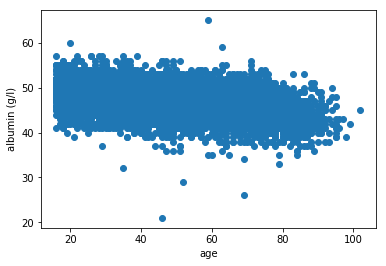

alkaline phosphatase (u/l)


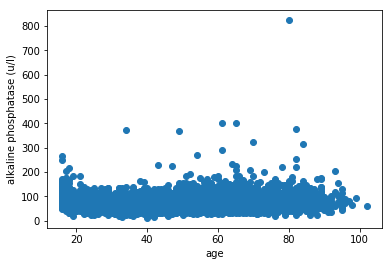

alanine transaminase (u/l)


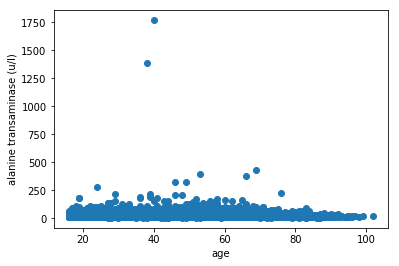

aspartate transaminase (u/l)


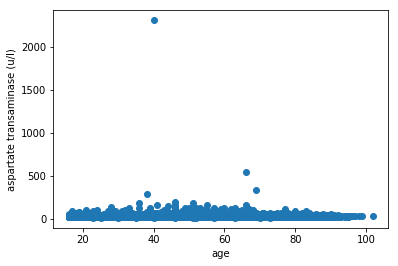

cholestrol (mmol/l)


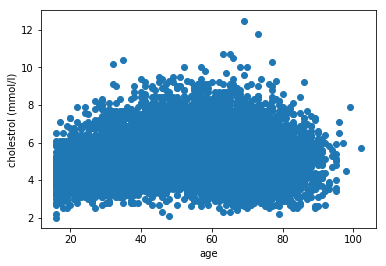

didehydroepiandrosterone sulphate (umol/l)


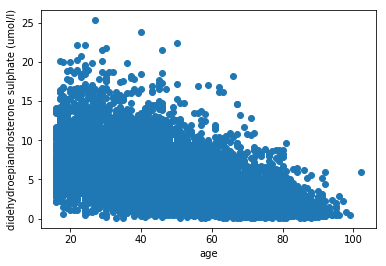

creatinine (umol/l)


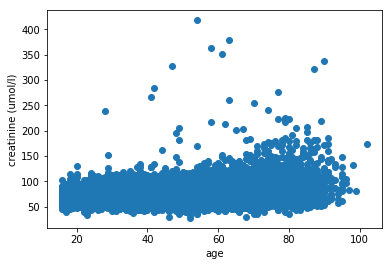

gamma glutamyltransferase (u/l)


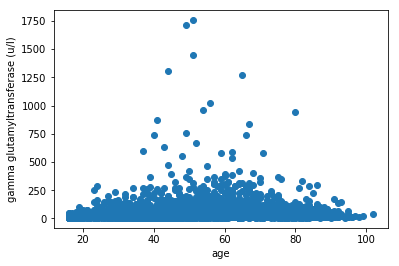

glycated haemoglobin (mmol/mol hb)


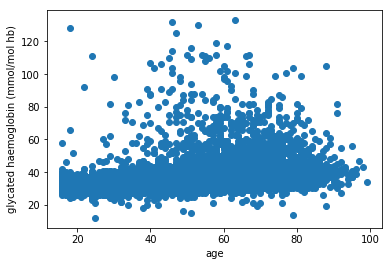

high-density lipoprotein cholesterol (mmol/l)


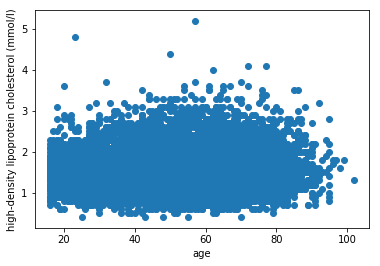

c-reactive protein (mg/l)


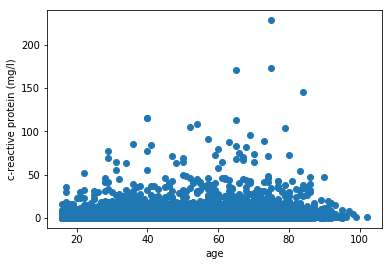

insulin-like growth factor 1 (nmol/l)


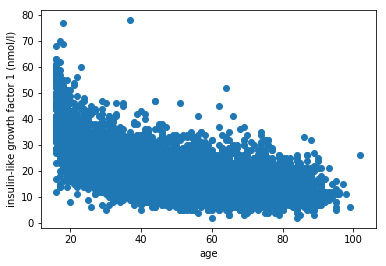

ferritin (ug/l)


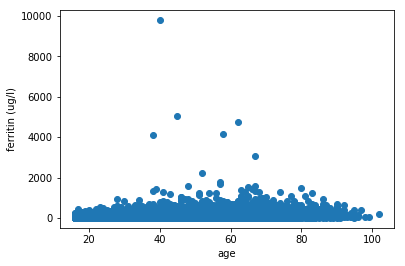

testosterone (nmol/l)


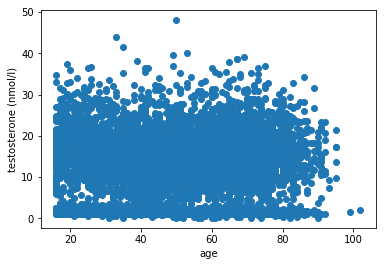

triglycerides (mmol/l)


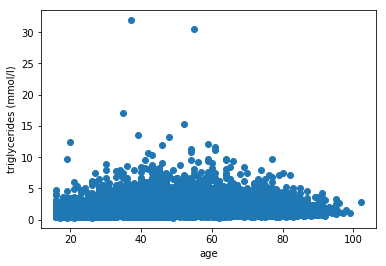

urea (mmol/l)


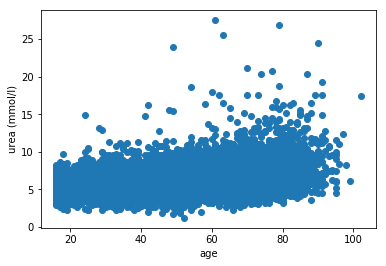

haemoglobin (g/l)


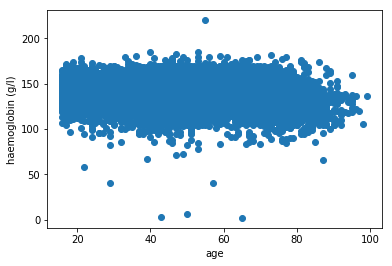

clauss fibrinogen (g/l)


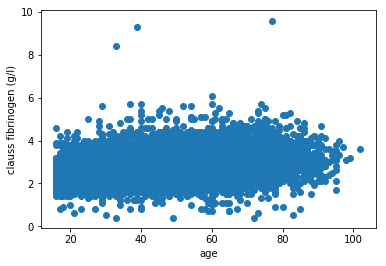

cytomegalovirus igg


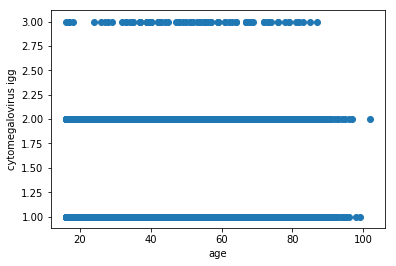

cytomegalovirus igm


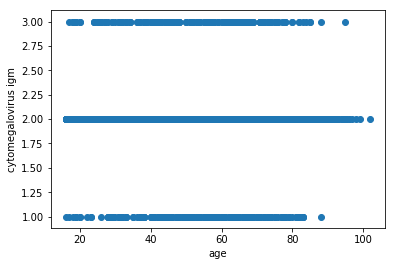

In [1072]:
plot_data(nurse_health['age'], nurse_biomarkers, 'age')

## Bonus

In reference to the link between inflammation and wellbeing that Sumeet shared, a quick visualization on CRP levels associated with inflammation to self-reported wellness.

clinical depression


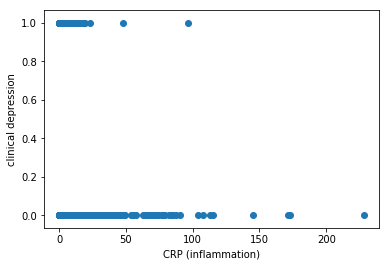

mental health meant accomplished less


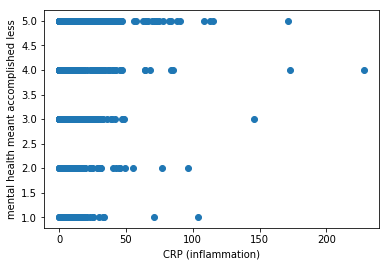

mental health meant worked less carefully


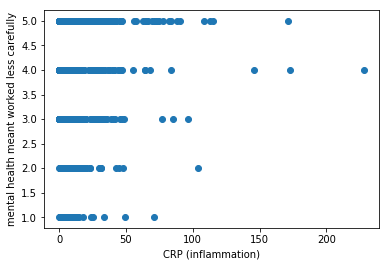

felt calm and peaceful


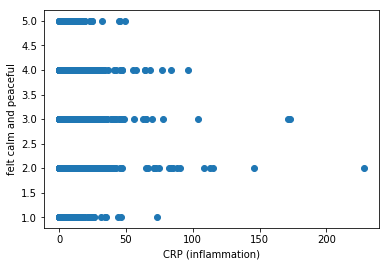

had lots of energy


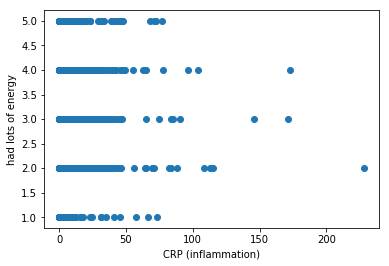

felt downhearted and depressed


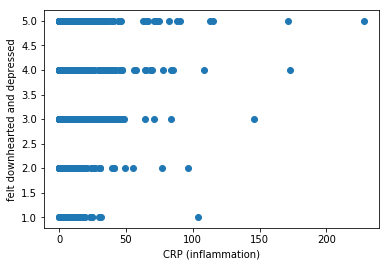

physical or mental health interfered with social life


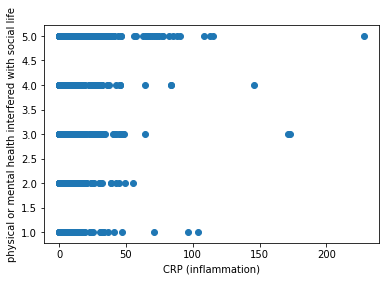

number of close friends


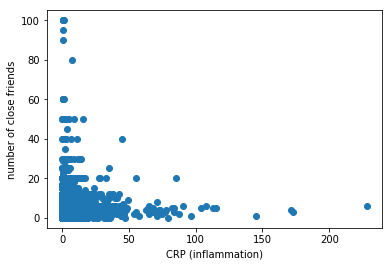

ever had an alcoholic drink


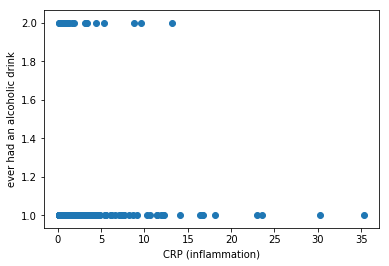

frequency of drug use


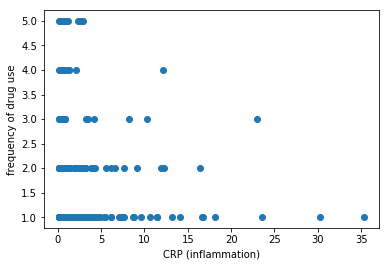

cannot work because of poor health


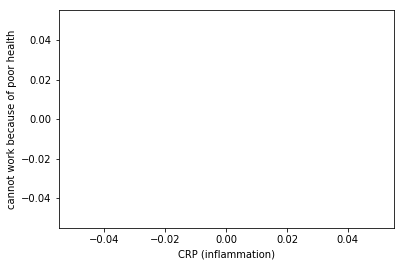

subjective well-being (likert)


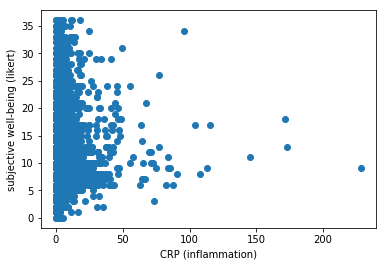

subjective well-being (caseness)


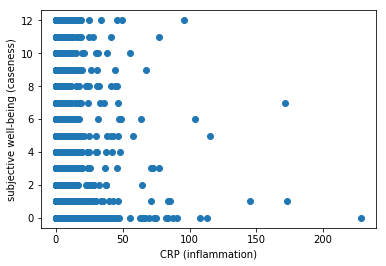

concentration


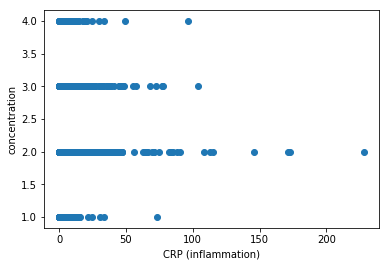

loss of sleep


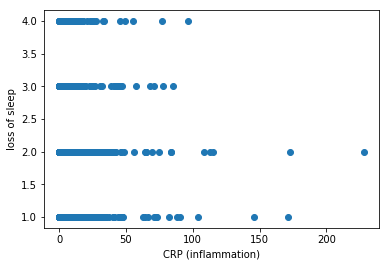

playing a useful role


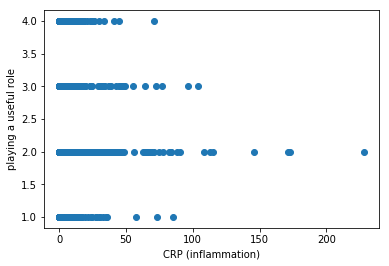

capable of making decisions


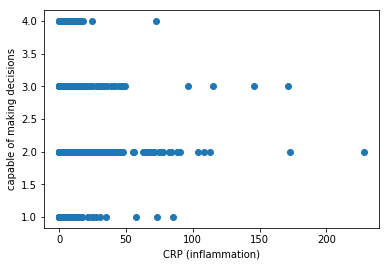

constantly under strain


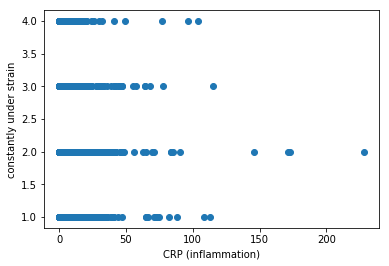

problem overcoming difficulties


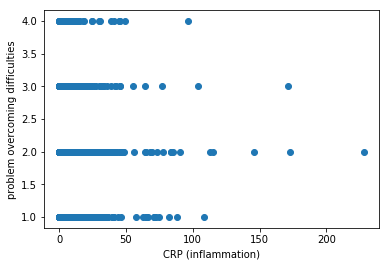

enjoy day-to-day activities


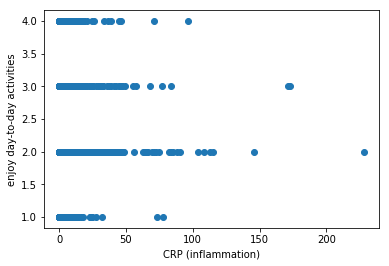

ability to face problems


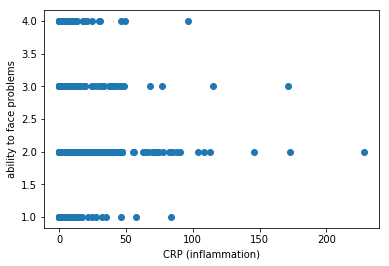

unhappy or depressed


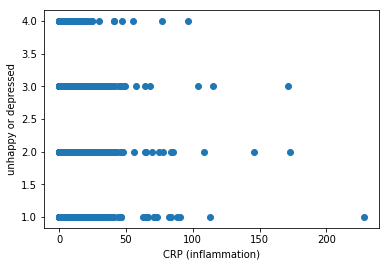

losing confidence


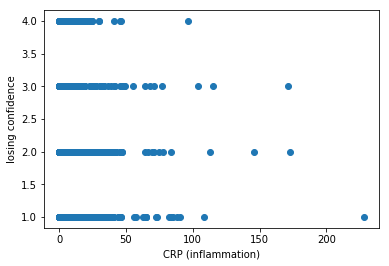

believe worthless


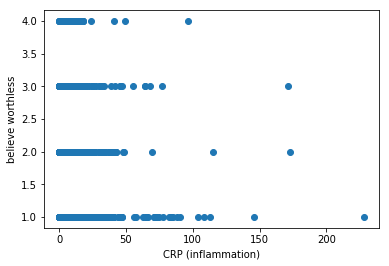

general happiness


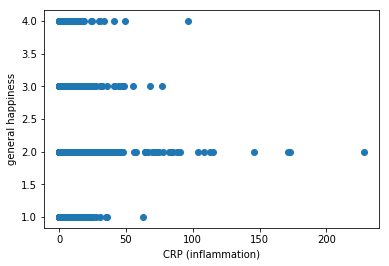

satisfaction with health


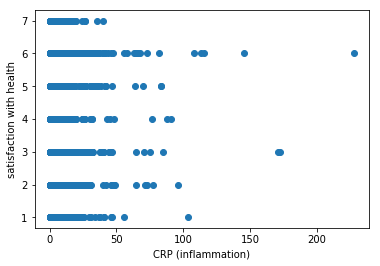

satisfaction with income


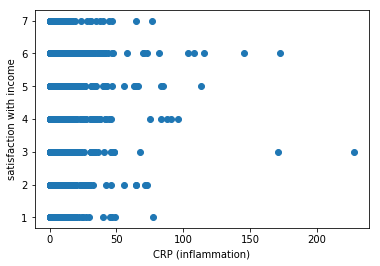

satisfaction with amount of leisure time


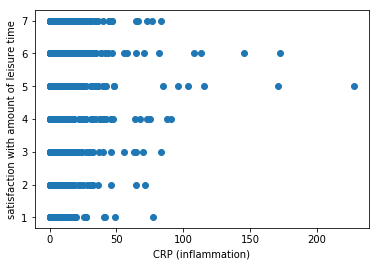

satisfaction with life overall


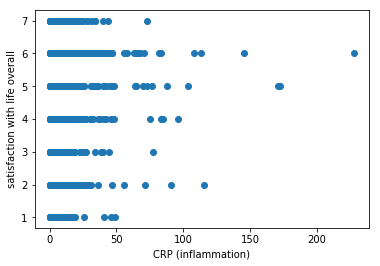

important to who you are: age


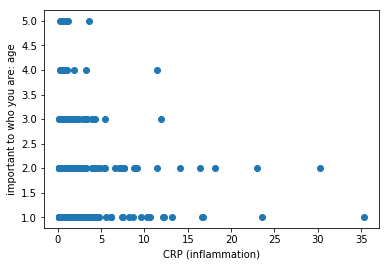

important to who you are: education


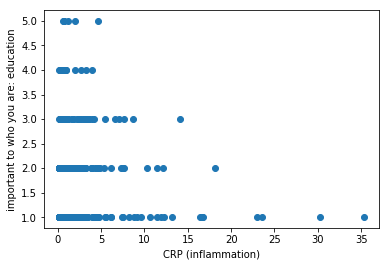

important to who you are: family


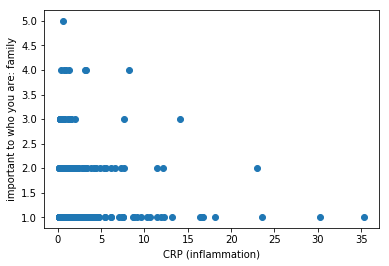

important to who you are: political beliefs


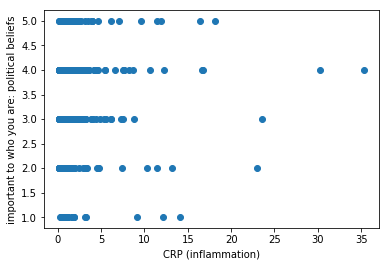

important to who you are: occupation


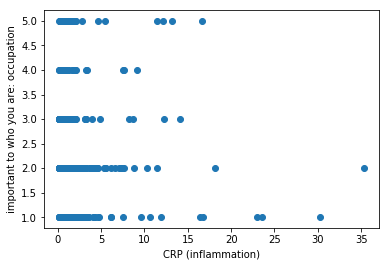

important to who you are: ethnicity


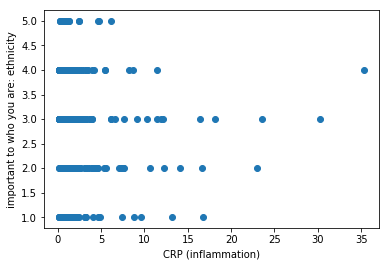

important to who you are: gender


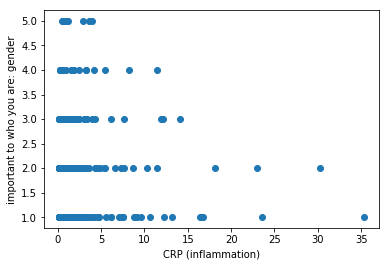

ever smoke cigarettes


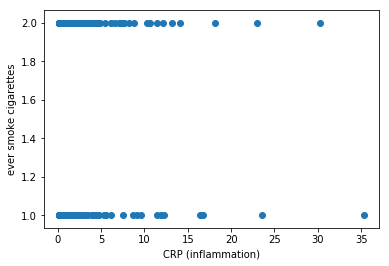

frequency of smoking


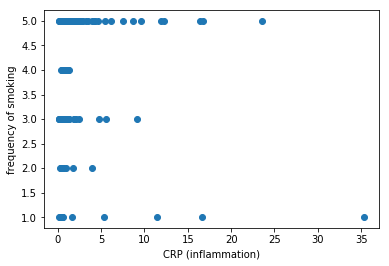

In [1074]:
plot_data(nurse_biomarkers['c-reactive protein (mg/l)'], ukhls_3_wellness, 'CRP (inflammation)')

## WIP

In [704]:
ukhls_3_net.to_csv('ukhls_3_net.csv')

In [426]:
ukhls_3_diff.to_csv('ukhls_3_diff.csv')

In [427]:
ukhls_3_dist.to_csv('ukhls_3_dist.csv')

In [ ]:
variables['nominee'] = {'netsx':'sex',
                        'netwr':'relation?',
                        'netrl':'relationship',
                        'netag':'age',
                        'netkn':'length of friendship',
                        'netph':'frequency of contact',
                        'netlv':'distance',
                        'netjb':'employment',
                        'netet':'ethnicity',
                        'netmet':'first meeting',
                        'netweb':'virtual',
                        'nettalk1':'talk about music',
                        'nettalk2':'talk about sport',
                        'nettalk3':'talk about work',
                        'nettalk4':'talk about politics',
                        'nettalk5':'talk about religion',
                        'nettalk6':'talk about family or children',
                        'nettalk7':'talk about books',
                        'nettalk8':'talk about magazines',
                        'nettalk9':'talk about films',
                        'nettalk10':'talk about tv',
                        'nettalk11':'talk about relationships',
                        'nettalk12':'talk about food and drink',
                        'nettalk13':'talk about travel',
                        'nettalk97':'talk of other hobbies or interests',
                        'nettalk96':'talk of none of these',
                        'netdo1':'watch sport',
                        'netdo2':'watch other tv',
                        'netdo3':'go to films concerts or other events',
                        'netdo4':'just talk',
                        'netdo5':'web chat',
                        'netdo6':'go to pubs cafes or clubs',
                        'netdo7':'go shopping',
                        'netdo8':'do sport or other exercise including walking',
                        'netdo9':'eat together',
                        'netdo10':'travel or take holidays together',
                        'netdo97':'do other hobbies together',
                        'netdo96':'do none of these',                        
                       }

In [ ]:
variables['seed'] = {'sex_dv':'sex',
                     'sexuor':'sexual orientation',
                     'racel_dv':'ethnicity',
                     'age_dv':'age',
                     'jbstat':'employment',
                    }

In [ ]:
variables['health'] = {'hcondn17':'clinical depression',
                       'scsf4a':'mental health meant accomplished less',
                       'scsf4b':'mental health meant worked less carefully',
                       'scsf6a':'felt calm and peaceful',
                       'scsf6b':'had lots of energy',
                       'scsf6c':'felt downhearted and depressed',
                       'scsf7':'physical or mental health interfered with social life',
                       'closenum':'how many close friends',
                       'evralc':'ever had an alcoholic drink',
                       'frdrg':'frequency of drug use',
                       'mlrnot11':'cannot work because of poor health',
                       'scghq1_dv':'subjective well-being (likert)',
                       'scghq2_dv':'subjective well-being (caseness)',
                       'scghqa':'concentration',
                       'scghqb':'loss of sleep',
                       'scghqc':'playing a useful role',
                       'scghqd':'capable of making decisions',
                       'scghqe':'constantly under strain',
                       'scghqf':'problem overcoming difficulties',
                       'scghqg':'enjoy day-to-day activities',
                       'scghqh':'ability to face problems',
                       'scghqi':'unhappy or depressed',
                       'scghqj':'losing confidence',
                       'scghqk':'believe worthless',
                       'scghql':'general happiness',
                       'sclfsat1':'satisfaction with health',
                       'sclfsat2':'satisfaction with income',
                       'sclfsat7':'satisfaction with amount of leisure time',
                       'sclfsato':'satisfaction with life overall',
                       'whoruage':'important to who you are: age',
                       'whoruedu':'important to who you are: education',
                       'whorufam':'important to who you are: family',
                       'whorupol':'important to who you are: political beliefs',
                       'whorupro':'important to who you are: occupation',
                       'whorurac':'important to who you are: ethnicity',
                       'whorusex':'important to who you are: gender',
                       'yphap':'feel about appearance',
                       'yphfm':'feel about family',
                       'yphfr':'feel about friends',
                       'yphlf':'feel about life as a whole',
                       'ypsdqf':'usually on my own',
                       'ypsdqg':'usually do as I am told',
                       'ypsdqh':'worry a lot',
                       'ypsdqj':'constantly fidgeting',
                       'ypsdqm':'often unhappy',
                       'ypsdqs':'other children bully me',
                       'ypsdqx':'many fears',
                       'evrsmo':'ever smoke cigarettes',
                       'smofrq':'frequency of smoking',
                       'ypevrsmo':'ever smoke cigarettes at all',
                      }

In [ ]:
info_desc = dict()
info_desc['egoalt'] = {'pdip':"cross-wave person identifier",
                       'apdip':"alter's cross-wave person identifier',
                       'esex':"ego's sex",
                       'asex':"alter's sex",
                       'relationship_dv':"ego's relationship to alter, edited",
                       'alwstat':"indicates co-residency in last wave",
                       'anwstat':"indicates co-residency in next wave"
                      }
info_desc['hhresp'] = {'carown':"hh member owns vehicle",
                       'cdelply':"place outside to play",
                       'cdepdo1':"go swimming once a month",
                       'cdepdo2':"do a hobby",
                       'cdepdo3':"have friends over",
                       'cdephave1':"family holiday",
                       'cdephave4':"celebrations on special occassions",
                       'cdeptrp':"child goes on school trips",
                       'cduse1':"colour tv",
                       'cduse10':"home pc",
                       'cduse6':"washing machine",
                       'cduse9':"microwave oven",
                       'cduse96':"none of the above appliances", #others material usage as well
                       'country':"country of residence e/w/s/ni",
                       'cplay':"toddler attends social group",
                       'fihhmngrs_dv':"gross household income: month before interview", #other income sources as well
                       'fihhmnpen_dv':"total household pension income: month before interview",
                       'fihhmnsben_dv':"total household social benefit income: month before interview",
                       'fuelhave1':"electricity",
                       'fuelhave2':"gas",
                       'gor_dv':"government office region",
                       'heatch':"central heating",
                       'hhdenus_xw':"cross-sectional household weight",
                       'hhsize':"number of people in hh",
                       'hhtype_dv':"composition of household", #other household composition numbers as well
                       'hidp':"household identifier"
                       'houscost1_dv':"monthly housing cost including mortgage principal payments",
                       'hsbeds':"number of bedrooms",
                       'hsownd':"house owned or rented",
                       'matdepa':"material deprivation: holiday", #other material deprivations as well
                       'matdepf':"material deprivation: savings",
                       'ncars':"number of cars",
                       'nemp_dv':"number of employed people in hh",
                       'nwage_dv':"number working age in hh",
                       'rent_dv':"monthly rent payment",
                       'tenure_dv':"housing tenure",
                       'urban_dv':"urban or rural",
                       'xpaltob_g3':"amount spent on alcohol",
                       'xpduely':"amount spent on fuel/electricty combined", #other expenditures as well
                       }
info_desc['indall'] = {'age_dv':"age of respondent",
                       'employ':"in paid employment",
                       'cohab_dv':"Lives with cohabitee in hh",
                       'country':"country of residence e/w/s/ni",
                       'fnpid':"natural father's pid",
                       'mnpid':"natural mother's pid", #similarly for step/adoptive/grand parents
                       'gor_dv':"government office region",
                       'hidp':"hh identifier",
                       'livesp_dv':"lives with spouse in hh",
                       'mastat_dv':"de facto marital status",
                       'nchild_dv':"number of own children in hh",
                       'newimm':"recent immigrant osm in household ",
                       'racel_dv':"ethnic group",
                       'sex_dv':"sex derived",
                       'single_dv':"single in hh",
                       'sppid':"spouse's pid",
                       'pidp':"person's pid"
                      }
info_desc['indresp'] = {'age_dv':"age of respondent",
                        'aglquit':"age when last stopped smoking",
                        'aidhh':"cares for elderly/sick in hh",
                        'artsXXXX':"took part in art rlated activities", #placeholder for now, too many options
                        'altcarXX':"mode of transport", #placeholder for now, too many options                        
                       }